# <a id='toc1_'></a>[Анализ изменения цены лечения в медицинской клинике](#toc0_)

## <a id='toc1_1_'></a>[Описание проекта](#toc0_)

Необходимо провести анализ изменения цены лечения в медицинской клинике в 2022 году относительно 2021 года.
Цель проекта - определить ключевые драйверы изменения цены лечения.

### <a id='toc1_1_1_'></a>[Термины кейса](#toc0_)

Визит - уникальное сочетание даты оказания услуги, застрахованного.

Медицинский кейс - последовательность медицинских услуг, полученных одним застрахованным лицом в одной клинике с интервалом между любыми соседними по дате услугами не более 14 дней.

Обратившийся в месяц - уникальное сочетание месяца оказания услуги и идентификатора месяца.

### <a id='toc1_1_2_'></a>[Гипотезы](#toc0_)
1. Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги.
2. Средняя стоимость обслуживания пациентов изменилась из-за изменения числа медицинских кейсов.
3. Средняя стоимость обслуживания пациентов изменилась из-за изменения стоимостей визитов.
4. Средняя стоимость обслуживания пациентов изменилась из-за изменения числа клиентов.

### <a id='toc1_1_3_'></a>[Описание датасета](#toc0_)

* `record_id` - уникальный идентификатор строки данных;
* `service_date` - дата оказания медицинской услуги;
* `service_name` - наименование медицинской услуги;
* `service_number` - количество услуг;
* `service_amount` - сумма выплат (стоимость оказанных услуг в рублях);
* `insured` - уникальный идентификатор пациента;
* `sex_id` - пол пациента;
* `age_for_service_date` - возраст пациента.

## **Содержание**<a id='toc0_'></a>    
- [Анализ изменения цены лечения в медицинской клинике](#toc1_)    
  - [Описание проекта](#toc1_1_)    
    - [Термины кейса](#toc1_1_1_)    
    - [Гипотезы](#toc1_1_2_)    
    - [Описание датасета](#toc1_1_3_)    
  - [Загрузка данных](#toc1_2_)    
  - [Предобработка данных](#toc1_3_)    
    - [Проверка пропусков](#toc1_3_1_)    
    - [Проверка типов данных](#toc1_3_2_)    
    - [Проверка дубликатов](#toc1_3_3_)    
    - [Проверка выбросов](#toc1_3_4_)    
    - [Обогощение данных](#toc1_3_5_)    
  - [Анализ данных](#toc1_4_)    
    - [Анализ услуг клиники](#toc1_4_1_)    
      - [Динамика доходов клиники](#toc1_4_1_1_)    
      - [Динамика цен в клинике](#toc1_4_1_2_)    
      - [Статистика клиентов клиники](#toc1_4_1_3_)    
    - [Статистика медицинских кейсов](#toc1_4_2_)    
  - [Общий вывод](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Загрузка данных](#toc0_)

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import datetime
import matplotlib.pyplot as plt
import re
from io import BytesIO  
import requests  

In [2]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [3]:
# https://docs.google.com/spreadsheets/d/1662B3-jj51eJn-kMpEt4JDj550a6TR-0zPZ9NzhXs1s/edit#gid=1132964387

spreadsheet_id = '1662B3-jj51eJn-kMpEt4JDj550a6TR-0zPZ9NzhXs1s' 
med_data = 'https://docs.google.com/spreadsheets/d/{}/export?format=xlsx'.format(spreadsheet_id)  
r = requests.get(med_data)  
data = pd.read_excel(BytesIO(r.content))  

# data = pd.read_excel('data_test_task_2022.xlsx')
pd.set_option('display.max_columns', None) # снимаем ограничение на количество столбцов
pd.set_option('display.max_colwidth', None) # снимаем ограничение на ширину столбцов

### Просмотр данных

In [4]:
data.head() # выводим на экран первые 5 записей

record_id service_date  \
0  30268157003   2021-01-24   
1  30268157103   2021-01-24   
2  30268157203   2021-01-24   
3  30268157303   2021-01-24   
4  30268157403   2021-01-24   

                                                                                     service_name  \
0                                                                                 Прием первичный   
1                        Взятие материала на посев, цитологическое исследование ( риноцитограмма)   
2  Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам   
3                                                   Общий анализ крови (лейкоцитарная форм,, СОЭ)   
4                                                                             Ревматоидный фактор   

   service_amount  service_number  insured  sex_id  age_for_service_date  
0            1470               1   490777     2.0                    26  
1             284               1   490777     2.0                    26  
2            1134               1   490777     2.0                    26  
3             693               1   490777     2.0                    26  
4             420               1   490777     2.0                    26

In [5]:
data.sample(15) # выводим на экран рандомные 15 записей

record_id service_date  \
56623  32327107503   2022-03-18   
43690  31814233103   2021-12-02   
68813  32631535103   2022-05-26   
13240  30786125003   2021-05-27   
60301  32510786903   2022-04-19   
7158   30489573903   2021-03-06   
61859  32510943703   2022-04-05   
45446  31996338903   2022-01-11   
70330  32631689003   2022-05-03   
52091  32112762503   2022-02-23   
54747  32326917903   2022-03-13   
17149  30961649303   2021-06-14   
45417  31996336003   2022-01-26   
39354  31680908803   2021-11-11   
12072  30786008003   2021-05-25   

                                          service_name  service_amount  \
56623                         Магнитотерапия (1 сеанс)            1090   
43690                                    Глюкоза крови             290   
68813                Исследование бинокулярного зрения             460   
13240                            Сеанс рефлексотерапии            1827   
60301           Прием травматолога-ортопеда, повторный            1380   
7158                     Интерпретация ЭКГ с описанием             525   
61859                   Прием эндокринолога, первичный            1540   
45446                      Прием кардиолога, повторный            1380   
70330                  Прием физиотерапевта, повторный            1380   
52091       Прижигание (туширование) при ЛОР патологии             680   
54747                   Прием офтальмолога,  первичный            1540   
17149                                         Мочевина             284   
45417  Дуплексное сканирование брахиоцефальных артерий            2760   
39354                         Прием хирурга, повторный            1380   
12072   Дуплексное сканирование вен нижних конечностей            2625   

       service_number  insured  sex_id  age_for_service_date  
56623               1   822675     1.0                    34  
43690               1   490833     2.0                    41  
68813               1  1072549     2.0                    64  
13240               1   266805     1.0                    38  
60301               1   935378     1.0                    30  
7158                1   512494     2.0                    35  
61859               1   935554     2.0                    39  
45446               1   744059     2.0                    42  
70330               1   873268     1.0                    32  
52091               1   634801     1.0                    45  
54747               1   873351     2.0                    37  
17149               1   512583     2.0                    38  
45417               1   716106     2.0                    36  
39354               1   716105     2.0                    38  
12072               1   596526     2.0                    32

In [6]:
data.info() # выводим на экран информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


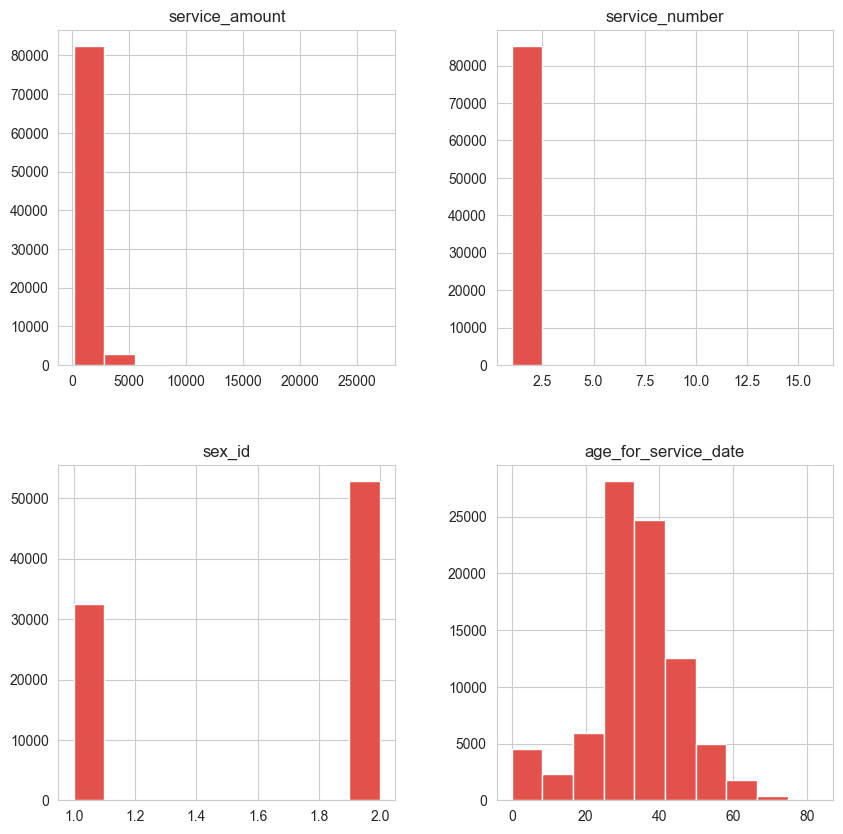

In [7]:
# устанавливаем стиль графиков
sns.set_style('whitegrid')
sns.set_palette('Spectral')
# визуализируем распределение данных
data[['service_amount', 'service_number', 'sex_id', 'age_for_service_date']].hist(figsize=(10, 10))
plt.show()

Данные из 85369 записей и 8 столбцов таблицы удалось успешно загрузить. Распределение значений, на первый взгляд, не вызывает вопросов. Было установлено наличие пропусков, необходимость изменения типа данных.
## <a id='toc1_3_'></a>[Предобработка данных](#toc0_)
### <a id='toc1_3_1_'></a>[Проверка пропусков](#toc0_)

In [8]:
temp = data.copy() # создаем копию датасета до преобразования
len(temp)

85369

In [9]:
data.isna().sum() # проверим пропуски

record_id                0
service_date             0
service_name             0
service_amount           0
service_number           0
insured                  0
sex_id                  21
age_for_service_date     0
dtype: int64

In [10]:
data[data['sex_id'].isna()] # посмотрим на записи с пропусками

record_id service_date  \
4411   30489299203   2021-03-18   
4412   30489299303   2021-03-27   
4413   30489299403   2021-03-27   
4414   30489299503   2021-03-27   
4415   30489299603   2021-03-27   
4416   30489299703   2021-03-27   
4417   30489299803   2021-03-27   
4418   30489299903   2021-03-27   
4419   30489300003   2021-03-27   
4420   30489300103   2021-03-27   
4421   30489300203   2021-03-27   
4422   30489300303   2021-03-27   
4423   30489300403   2021-03-27   
4424   30489300503   2021-03-29   
4425   30489300603   2021-03-29   
8880   30620882903   2021-04-22   
8881   30620883003   2021-04-29   
12357  30786036703   2021-05-31   
17987  30961733903   2021-06-21   
18016  30961736803   2021-06-22   
18017  30961736903   2021-06-22   

                                         service_name  service_amount  \
4411                                  Прием первичный            1470   
4412    Общий анализ крови (лейкоцитарная форм,, СОЭ)             693   
4413                                Общий анализ мочи             431   
4414                    Альфа-амилаза панкреатическая             287   
4415                     АЛТ (аланинаминотрансфераза)             278   
4416                   АСТ (аспартатаминотрансфераза)             242   
4417                                  Билирубин общий             287   
4418                ГГТ (гамма - глютамилтрансфераза)             287   
4419                                    Глюкоза крови             273   
4420                               Фосфотаза щелочная             287   
4421              Взятие крови из периферической вены             158   
4422                       Эзофагогастродуоденоскопия            2678   
4423      Ультразвуковое исследование брюшной полости            2100   
4424                                  Прием первичный            1470   
4425                                  Прием повторный            1313   
8880                                  Прием первичный            1470   
8881                                  Прием повторный            1313   
12357                                 Прием первичный            1470   
17987                                 Прием повторный            1313   
18016                                 Прием первичный            1470   
18017  Дуплексное сканирование вен нижних конечностей            2625   

       service_number  insured  sex_id  age_for_service_date  
4411                1   512590     NaN                    26  
4412                1   512590     NaN                    26  
4413                1   512590     NaN                    26  
4414                1   512590     NaN                    26  
4415                1   512590     NaN                    26  
4416                1   512590     NaN                    26  
4417                1   512590     NaN                    26  
4418                1   512590     NaN                    26  
4419                1   512590     NaN                    26  
4420                1   512590     NaN                    26  
4421                1   512590     NaN                    26  
4422                1   512590     NaN                    26  
4423                1   512590     NaN                    26  
4424                1   512590     NaN                    26  
4425                1   512590     NaN                    26  
8880                1   221581     NaN                    42  
8881                1   221581     NaN                    42  
12357               1   221581     NaN                    42  
17987               1   221581     NaN                    42  
18016               1   512590     NaN                    26  
18017               1   512590     NaN                    26

In [11]:
# подсчитаем долю пропусков в колонке `кампании`
data_isna_share = data['sex_id'].isna().sum() / data.shape[0]
print(f'Доля пропусков в процентах составляет: {data_isna_share :.2%}')

Доля пропусков в процентах составляет: 0.02%


Пропусков очень мало. Их следует удалить для корректной работы с данными столбца.

In [12]:
data = data.dropna(subset='sex_id')

In [13]:
# проверка потерь
a, b = len(temp), len(data)
print(len(temp), len(data), round((a-b)/a*100, 2))

85369 85348 0.02


### <a id='toc1_3_2_'></a>[Проверка типов данных](#toc0_)

In [14]:
data.dtypes

record_id                 int64
service_date             object
service_name             object
service_amount            int64
service_number            int64
insured                   int64
sex_id                  float64
age_for_service_date      int64
dtype: object

Следует привести дату и пол к корректному типу данных.

In [15]:
data['service_date'] = pd.to_datetime(data['service_date'])
data['sex_id'] = data['sex_id'].astype('int')

In [16]:
data.dtypes

record_id                        int64
service_date            datetime64[ns]
service_name                    object
service_amount                   int64
service_number                   int64
insured                          int64
sex_id                           int32
age_for_service_date             int64
dtype: object

### <a id='toc1_3_3_'></a>[Проверка дубликатов](#toc0_)

In [17]:
temp = data.copy() # создаем копию датасета до преобразования
len(temp)

85348

In [18]:
data.duplicated().sum() # сумма явных дубликатов

0

Явных дубликатов не обнаружено

In [19]:
data.nunique() # число уникальных значений по столбцам

record_id               85348
service_date              602
service_name              875
service_amount            535
service_number             13
insured                  4487
sex_id                      2
age_for_service_date       76
dtype: int64

In [20]:
print('Минимальная дата обращения:', data.service_date.min())
print('Максимальная дата обращения:', data.service_date.max())

Минимальная дата обращения: 2021-01-03 00:00:00
Максимальная дата обращения: 2022-08-31 00:00:00


In [21]:
data.service_name.unique()

array(['Прием первичный',
       'Взятие материала на посев, цитологическое исследование ( риноцитограмма)',
       'Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам',
       'Общий анализ крови (лейкоцитарная форм,, СОЭ)',
       'Ревматоидный фактор', 'С-реактивный белок',
       'Взятие крови из периферической вены', 'Магнитотерапия (1 сеанс)',
       'УВЧ-терапия (1 сеанс) (1 поле)', 'Прием повторный',
       'Смазывание глотки лекарственными формами', 'Взятие мазка',
       'Обработка вульвы', 'Обработка шейки матки',
       'Гинекологический мазок', 'Общий анализ мочи', 'Креатинин',
       'Мочевая кислота', 'Мочевина', 'Общий белок',
       'Ультразвуковое исследование почек и надпочечников',
       'Ультразвуковое исследование мочевого пузыря',
       'ЛПНП (липопротеиды низкой плотности, бета-липопротеиды)',
       'Триглицериды', 'Холестерин', 'АЛТ (аланинаминотрансфераза)',
       'Альдостерон', 'Кортизол (кровь)', 'Ренин + Ангио

In [22]:
print('Было уникальных значений:', data.service_name.nunique())
# исправление опечаток
data['service_name'] = data['service_name'].str.strip()
data['service_name'] = data['service_name'].str.lower()
data.service_name = data.service_name.apply(lambda x: re.sub(r'[,"()\'.]', '', x))
data['service_name'] = data['service_name'].str.replace('  ', ' ')
data['service_name'] = data['service_name'].str.replace('эхокардиография', 'экг')
data['service_name'] = data['service_name'].str.replace('ультразвуковое исследование', 'узи')
print('Теперь уникальных значений:', data.service_name.nunique())

Было уникальных значений: 875
Теперь уникальных значений: 868


In [23]:
data.service_number.unique()

array([ 1,  2,  3,  4, 12,  5, 11, 13,  7,  6, 16, 15, 14], dtype=int64)

В рамках одного обращения было зафиксировано от 1 до 16 оказанных услуг.

In [24]:
data.sex_id.unique()

array([2, 1])

В таблице информация о пациентах двух полов. В дальнейшем будет установлено, какой пол за какой цифрой закреплён.

In [25]:
data.age_for_service_date.unique()

array([26, 25, 40, 35, 43, 48, 36,  2, 30,  1, 44, 32,  0, 28, 34,  4, 37,
       33, 38, 49, 45, 39, 51, 31, 23, 24, 27, 16,  5, 13, 42, 11, 29, 21,
        3, 65, 60,  6, 55, 68, 52, 47, 58,  8, 22, 50, 63,  7, 53, 62, 46,
       56,  9, 41, 61, 57, 14, 54, 10, 15, 18, 19, 12, 59, 17, 67, 83, 64,
       72, 20, 70, 66, 74, 75, 71, 69], dtype=int64)

In [26]:
# поиск и удаление дубликатов по конкретным полям
print('Записей в таблице до удаления дубликатов:', data.shape[0])
print(data.duplicated(subset=['insured', 'service_name', 'service_date', 'service_amount']).sum())

print(data[data.duplicated(subset=['insured', 'service_name', 'service_date', 'service_amount'], keep=False)]
      [['insured', 'service_name', 'service_date', 'service_amount']])
data = data.drop_duplicates(subset=['insured', 'service_name', 'service_date', 'service_amount'], keep='first')
print('Записей в таблице после удаления дубликатов:', data.shape[0])

Записей в таблице до удаления дубликатов: 85348
1348
       insured                                              service_name  \
49      418179                                           прием первичный   
90      402409                                           прием повторный   
93      402409                                           прием повторный   
104     418179                                           прием первичный   
142     166120                                           прием повторный   
...        ...                                                       ...   
81340   629910                       взятие крови из периферической вены   
83240  1302956                  исследование отделяемого молочной железы   
83241  1302956                  исследование отделяемого молочной железы   
85246  1302824  вмышечная инъекция за 1 процедуру без стоимости лекарств   
85247  1302824  вмышечная инъекция за 1 процедуру без стоимости лекарств   

      service_date  service_amount

In [27]:
# проверка потерь
a, b = len(temp), len(data)
print(len(temp), len(data), round((a-b)/a*100, 2))

85348 84000 1.58


### <a id='toc1_3_4_'></a>[Проверка выбросов](#toc0_)

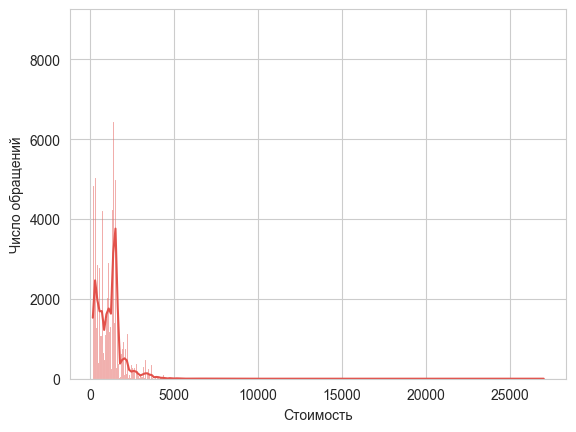

Число услуг дороже 4000 рублей: 581
Число услуг дороже 5000 рублей: 265
Число услуг дороже 6000 рублей: 168
Число услуг дороже 10000 рублей: 13
Число услуг дороже 20000 рублей: 1


In [28]:
sns.histplot(data['service_amount'], kde=True)
plt.xlabel('Стоимость')
plt.ylabel('Число обращений')
plt.show()
print('Число услуг дороже 4000 рублей:', data[data['service_amount'] > 4000]['service_amount'].count())
print('Число услуг дороже 5000 рублей:', data[data['service_amount'] > 5000]['service_amount'].count())
print('Число услуг дороже 6000 рублей:', data[data['service_amount'] > 6000]['service_amount'].count())
print('Число услуг дороже 10000 рублей:', data[data['service_amount'] > 10000]['service_amount'].count())
print('Число услуг дороже 20000 рублей:', data[data['service_amount'] > 20000]['service_amount'].count())

In [29]:
hp6 = data.query('service_amount > 6000')
display(hp6)
display(hp6.describe())

record_id service_date                             service_name  \
565    30268213503   2021-01-22  вскрытие абсцесса различной локализации   
637    30268220703   2021-01-10  вскрытие абсцесса различной локализации   
1983   30268355603   2021-01-27                  удаление вросшего ногтя   
2040   30346791203   2021-02-09  вскрытие абсцесса различной локализации   
2707   30346869203   2021-02-23    сеанс sis терапии длинный цикл 1 зона   
...            ...          ...                                      ...   
83457  33177813903   2022-08-25        вскрытие абсцедирующего фурункула   
84248  33177966103   2022-08-31                         удаление атеромы   
84562  33178018103   2022-08-29               мрт тазобедренных суставов   
85058  33178103103   2022-08-26        мскт мягких тканей шеи с фонацией   
85341  33178144403   2022-08-09             вакцинация вакциной менактра   

       service_amount  service_number  insured  sex_id  age_for_service_date  
565              6405               1   386877       1                    48  
637              6405               1   402161       2                    35  
1983             6300               1   168236       1                    13  
2040             6405               1   240061       2                    29  
2707             6930               2   490612       2                    62  
...               ...             ...      ...     ...                   ...  
83457           11200               2  1302507       2                    33  
84248            6950               1  1302646       1                    27  
84562            7720               1   576389       1                    25  
85058            8270               1  1155117       1                    59  
85341            9000               1  1155165       2                     0  

[168 rows x 8 columns]

record_id                   service_date  service_amount  \
count  1.680000e+02                            168      168.000000   
mean   3.168489e+10  2021-11-09 07:08:34.285714176     7578.089286   
min    3.026821e+10            2021-01-10 00:00:00     6060.000000   
25%    3.096167e+10            2021-06-20 18:00:00     6300.000000   
50%    3.148562e+10            2021-10-17 12:00:00     6930.000000   
75%    3.251106e+10            2022-04-16 00:00:00     7720.000000   
max    3.317814e+10            2022-08-31 00:00:00    26999.000000   
std    8.633372e+08                            NaN     2401.601571   

       service_number       insured      sex_id  age_for_service_date  
count      168.000000  1.680000e+02  168.000000            168.000000  
mean         1.422619  6.491594e+05    1.595238             39.136905  
min          1.000000  1.424470e+05    1.000000              0.000000  
25%          1.000000  4.906140e+05    1.000000             30.000000  
50%          1.000000  6.519670e+05    2.000000             37.000000  
75%          2.000000  7.613360e+05    2.000000             46.000000  
max          5.000000  1.306792e+06    2.000000             70.000000  
std          0.754206  2.672519e+05    0.492313             12.514387

In [30]:
hp10 = data.query('service_amount > 10000')
display(hp10)
display(hp10.describe())

record_id service_date  \
8316   30620826503   2021-04-13   
15588  30961493203   2021-06-17   
16373  30961571703   2021-06-06   
16564  30961590803   2021-06-06   
18518  30961787003   2021-06-24   
18519  30961787103   2021-06-24   
23794  31249334503   2021-08-20   
27994  31408821503   2021-09-09   
36348  31680600903   2021-11-07   
36760  31680642403   2021-11-20   
37286  31680697303   2021-11-10   
83450  33177813203   2022-08-26   
83457  33177813903   2022-08-25   

                                                                                             service_name  \
8316                                 мскт почек и надпочечников с внутривенным болюсным контрастированием   
15588                    мрт брюшной полости и забрюшинного пространства с внутривенным контрастированием   
16373                            мскт мочевыделительной системы с внутривенным болюсным контрастированием   
16564                                                             вскрытие абсцесса различной локализации   
18518                                            тотальная внутривенная анестезия от 20 минут до 60 минут   
18519                                                                гистерорезектоскопия при полипах рдв   
23794                                                  мрт головного мозга и гипофиза с контрастированием   
27994                    мультипараметрическая мрт предстательной железы с динамическим контрастированием   
36348  мскт органов брюшной полости и забрюшинного пространства с внутривенным болюсным контрастированием   
36760  мскт органов брюшной полости и забрюшинного пространства с внутривенным болюсным контрастированием   
37286                                            мрт органов малого таза с внутривенным контрастированием   
83450                                                                               мрт коленного сустава   
83457                                                                   вскрытие абсцедирующего фурункула   

       service_amount  service_number  insured  sex_id  age_for_service_date  
8316            11025               1   544444       1                    31  
15588           17325               1   634755       1                    41  
16373           12075               1   634765       1                    42  
16564           12810               2   181718       2                    34  
18518           11550               1   362928       2                    51  
18519           26999               1   362928       2                    51  
23794           15225               1   544627       2                    34  
27994           14175               1   531654       1                    59  
36348           12680               1   716141       2                    31  
36760           12680               1   743829       1                    42  
37286           13780               1   596539       2                    27  
83450           13000               2  1306792       2                    27  
83457           11200               2  1302507       2                    33

record_id                   service_date  service_amount  \
count  1.300000e+01                             13       13.000000   
mean   3.149883e+10  2021-10-01 20:18:27.692307712    14194.153846   
min    3.062083e+10            2021-04-13 00:00:00    11025.000000   
25%    3.096159e+10            2021-06-17 00:00:00    12075.000000   
50%    3.124933e+10            2021-08-20 00:00:00    12810.000000   
75%    3.168064e+10            2021-11-10 00:00:00    14175.000000   
max    3.317781e+10            2022-08-26 00:00:00    26999.000000   
std    8.175786e+08                            NaN     4217.215528   

       service_number       insured     sex_id  age_for_service_date  
count       13.000000  1.300000e+01  13.000000             13.000000  
mean         1.230769  6.510482e+05   1.615385             38.692308  
min          1.000000  1.817180e+05   1.000000             27.000000  
25%          1.000000  5.316540e+05   1.000000             31.000000  
50%          1.000000  5.965390e+05   2.000000             34.000000  
75%          1.000000  7.161410e+05   2.000000             42.000000  
max          2.000000  1.306792e+06   2.000000             59.000000  
std          0.438529  3.283783e+05   0.506370             10.044772

Все суммы в основном в пределах 5000 рублей, что соответствует нормальной стоимости стандартных медицинских услуг.

Дорогие услуги оправдывают свою стоимость: дорого стоят микрооперации (вскрытия, удаления) и некоторые другие непопулярные услуги. Достаточно дорогостоящими являются мрт, анастезия и мскт. Есть ещё одна операция дороже 26 000 рублей.

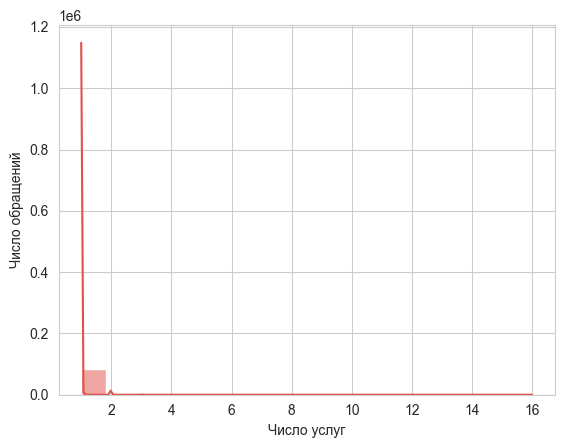

In [31]:
sns.histplot(data["service_number"], kde=True)
plt.xlabel('Число услуг')
plt.ylabel('Число обращений')
plt.show()

Чаще всего количество услуг не суммируется, что тоже в порядке нормы.

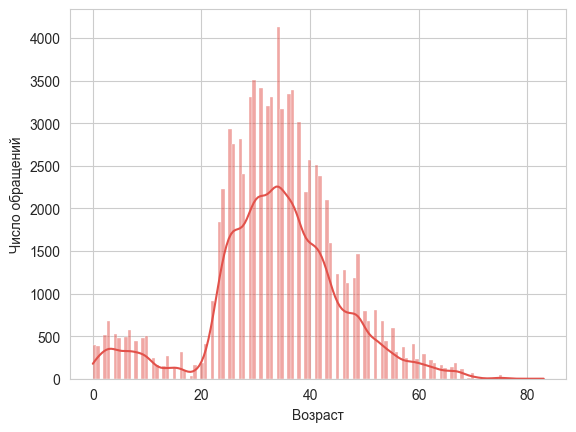

In [32]:
sns.histplot(data["age_for_service_date"], kde=True)
plt.xlabel('Возраст')
plt.ylabel('Число обращений')
plt.show()

График распределения возраста очень напоминает график нормального распределения. Большинство обращений происходит от клиентов среднего возраста. Часть пациентов детского и подросткового возраста.
### <a id='toc1_3_5_'></a>[Обогощение данных](#toc0_)

#### Пол пациентов

In [33]:
fem = data.query('service_name == "гинекологический мазок"')
display(fem.head(5))
fem.sex_id.unique().tolist()

record_id service_date            service_name  service_amount  \
16   30268158603   2021-01-27  гинекологический мазок             525   
145  30268171503   2021-01-21  гинекологический мазок             525   
151  30268172103   2021-01-25  гинекологический мазок             525   
156  30268172603   2021-01-23  гинекологический мазок             525   
268  30268183803   2021-01-15  гинекологический мазок             525   

     service_number  insured  sex_id  age_for_service_date  
16                1   232418       2                    25  
145               1   166120       2                    33  
151               1   535243       2                    38  
156               1   210891       2                    40  
268               1   490772       2                    35

[2]

Гинекологический мазок взяли только у клиентов со значением `sex_id`, равным 2. Следовательно, 2 - это женщины.

In [34]:
def categorize_sex(sex_id):
    try:
        if sex_id == 2:
            return 'женщины'
        else:
            return 'мужчины'
    except:
        pass

In [35]:
data['sex_category'] = data['sex_id'].apply(categorize_sex)
data.head()

record_id service_date  \
0  30268157003   2021-01-24   
1  30268157103   2021-01-24   
2  30268157203   2021-01-24   
3  30268157303   2021-01-24   
4  30268157403   2021-01-24   

                                                                                    service_name  \
0                                                                                прием первичный   
1                           взятие материала на посев цитологическое исследование риноцитограмма   
2  посев отдел дыхательных путей - слизистая зева с определением чувствительности к антибиотикам   
3                                                      общий анализ крови лейкоцитарная форм соэ   
4                                                                            ревматоидный фактор   

   service_amount  service_number  insured  sex_id  age_for_service_date  \
0            1470               1   490777       2                    26   
1             284               1   490777       2                    26   
2            1134               1   490777       2                    26   
3             693               1   490777       2                    26   
4             420               1   490777       2                    26   

  sex_category  
0      женщины  
1      женщины  
2      женщины  
3      женщины  
4      женщины

#### Цена услуг и временные данные

In [36]:
# создание столбцов с количественными данными
data['price'] = data['service_amount'] / data['service_number']
data['month_cal'] = data['service_date'].dt.to_period('M').dt.to_timestamp()
data['weekday'] = data['service_date'].dt.weekday # где 0 - понедельник
data['month'] = data['service_date'].dt.month
data['year'] = data['service_date'].dt.year
data['month_year'] = data['service_date'].dt.to_period('M')
data['mnth_yr'] = data['service_date'].apply(lambda x:x.strftime('%Y-%B')) 
data.sample(5)

record_id service_date  \
12268  30786027803   2021-05-12   
65710  32631221103   2022-05-14   
14627  30786263703   2021-05-05   
27670  31408789003   2021-09-05   
40184  31813873903   2021-12-14   

                                            service_name  service_amount  \
12268                             магнитотерапия 1 сеанс            1040   
65710                                  общий анализ мочи             450   
14627       узи гинекология трансвагинально с дс сосудов            2100   
27670                                    прием повторный            1313   
40184  рентгенография органов грудной клетки 2 проекции             1920   

       service_number  insured  sex_id  age_for_service_date sex_category  \
12268               1   156718       2                    27      женщины   
65710               1   402409       2                    37      женщины   
14627               1   544855       2                    49      женщины   
27670               1   584585       1                    59      мужчины   
40184               1   774357       2                    31      женщины   

        price  month_cal  weekday  month  year month_year         mnth_yr  
12268  1040.0 2021-05-01        2      5  2021    2021-05        2021-May  
65710   450.0 2022-05-01        5      5  2022    2022-05        2022-May  
14627  2100.0 2021-05-01        2      5  2021    2021-05        2021-May  
27670  1313.0 2021-09-01        6      9  2021    2021-09  2021-September  
40184  1920.0 2021-12-01        1     12  2021    2021-12   2021-December

In [37]:
# создание медицинских кейсов
data_new = data.sort_values('insured')
data_new['diff'] = data_new.groupby('insured')['service_date'].diff(1)
sessions_start_df = data_new[(data_new['diff'].isnull()) | (data_new['diff'] > '1209600 seconds')]
sessions_start_df['session_id'] = sessions_start_df['record_id']
data_new = data_new.sort_values('record_id')
sessions_start_df = sessions_start_df.sort_values('record_id')
data_new = pd.merge_asof(data_new,sessions_start_df[['record_id','insured','session_id']],on='record_id',by='insured')
data_new['between_services'] = data_new.groupby(['insured','session_id'])['service_date'].diff(1)
data_new['between_services'] = data_new.groupby(['insured','session_id'])['between_services'].shift(-1)
data_new

C:\Users\daria\AppData\Local\Temp\ipykernel_2748\878824629.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_start_df['session_id'] = sessions_start_df['record_id']


record_id service_date  \
0      30268157003   2021-01-24   
1      30268157103   2021-01-24   
2      30268157203   2021-01-24   
3      30268157303   2021-01-24   
4      30268157403   2021-01-24   
...            ...          ...   
83995  33178146803   2022-08-20   
83996  33178146903   2022-08-20   
83997  33178147003   2022-08-20   
83998  33178147103   2022-08-20   
83999  33178147203   2022-08-20   

                                                                                        service_name  \
0                                                                                    прием первичный   
1                               взятие материала на посев цитологическое исследование риноцитограмма   
2      посев отдел дыхательных путей - слизистая зева с определением чувствительности к антибиотикам   
3                                                          общий анализ крови лейкоцитарная форм соэ   
4                                                                                ревматоидный фактор   
...                                                                                              ...   
83995                                                                              общий анализ мочи   
83996                                                      общий анализ крови лейкоцитарная форм соэ   
83997                                          ачтв активированное частичное тромбопластиновое время   
83998                                                                                 протромбин мно   
83999                                                                                гепатит в hbsag   

       service_amount  service_number  insured  sex_id  age_for_service_date  \
0                1470               1   490777       2                    26   
1                 284               1   490777       2                    26   
2                1134               1   490777       2                    26   
3                 693               1   490777       2                    26   
4                 420               1   490777       2                    26   
...               ...             ...      ...     ...                   ...   
83995             495               1   935341       2                    30   
83996             800               1   935341       2                    30   
83997             300               1   935341       2                    30   
83998             410               1   935341       2                    30   
83999             570               1   935341       2                    30   

      sex_category   price  month_cal  weekday  month  year month_year  \
0          женщины  1470.0 2021-01-01        6      1  2021    2021-01   
1          женщины   284.0 2021-01-01        6      1  2021    2021-01   
2          женщины  1134.0 2021-01-01        6      1  2021    2021-01   
3          женщины   693.0 2021-01-01        6      1  2021    2021-01   
4          женщины   420.0 2021-01-01        6      1  2021    2021-01   
...            ...     ...        ...      ...    ...   ...        ...   
83995      женщины   495.0 2022-08-01        5      8  2022    2022-08   
83996      женщины   800.0 2022-08-01        5      8  2022    2022-08   
83997      женщины   300.0 2022-08-01        5      8  2022    2022-08   
83998      женщины   410.0 2022-08-01        5      8  2022    2022-08   
83999      женщины   570.0 2022-08-01        5      8  2022    2022-08   

            mnth_yr      diff    session_id between_services  
0      2021-January -163 days           NaN              NaT  
1      2021-January  -53 days           NaN              NaT  
2      2021-January    0 days           NaN              NaT  
3      2021-January    0 days           NaN              NaT  
4      2021-January    0 days           NaN              NaT  
...             ...       ...           ...              ...  
83995   2022-August   14 days  3.317815e+10     

In [38]:
data_new['session_id'].nunique() # количество медицинских кейсов

16930

In [39]:
data_with_case = data_new.dropna(subset='session_id') # оставляем только кейсы в новой таблице

In [40]:
data['service_name'].unique()

array(['прием первичный',
       'взятие материала на посев цитологическое исследование риноцитограмма',
       'посев отдел дыхательных путей - слизистая зева с определением чувствительности к антибиотикам',
       'общий анализ крови лейкоцитарная форм соэ', 'ревматоидный фактор',
       'с-реактивный белок', 'взятие крови из периферической вены',
       'магнитотерапия 1 сеанс', 'увч-терапия 1 сеанс 1 поле',
       'прием повторный', 'смазывание глотки лекарственными формами',
       'взятие мазка', 'обработка вульвы', 'обработка шейки матки',
       'гинекологический мазок', 'общий анализ мочи', 'креатинин',
       'мочевая кислота', 'мочевина', 'общий белок',
       'узи почек и надпочечников', 'узи мочевого пузыря',
       'лпнп липопротеиды низкой плотности бета-липопротеиды',
       'триглицериды', 'холестерин', 'алт аланинаминотрансфераза',
       'альдостерон', 'кортизол кровь', 'ренин + ангиотензин 1', 'т4 св',
       'ттг тиреотропин', 'аст аспартатаминотрансфераза',
      

In [41]:
# создание словаря для широкой классификации
classification_dict = {'консультация':['прием','осмотр','консультация'],                       
                       'лечение':['терапия','токи','сеанс','форез','массаж','подбор','инъекция','анестезия',\
                                   'промывание','лечение','туалет','блокада','перевязка','смазывание','удаление',\
                                   'инстилляция','продувание','обработка','инстиляция','аппликация',\
                                   'швов','инфузия','повязк','лекарст','иммобил','вскрыт','введен','лфк','компрес',\
                                   'тампонада','лечеб','катетер','вакцинация','ингаляция','санац','репозиц',\
                                   'зондирование','шинирование','криодеструкция','пребывание','коагуляция',                                   
                                   'пункция с введением лекарственного средства','лечебная пункция','лечебно-диагностическая',\
                                   'пункция гайморовой пазухи'],\
                        'диагностика':['метрия','ультразвук','экг','глазн','графия',\
                                     'сканирование','бинокул','скопия','эндоскоп','монитор','диагност',\
                                     'расшиф','функц','вестибул','узи','камертон','пункц','пункт',\
                                     'биопсия','мскт','цитолог','мрт','цветоощущ','пренатал']}

Исходя из значений `service_name` и указанных категорий, в группу `другое` по большей мере попадает сдача различных анализов.

In [42]:
# ф-ция классификации
def categories(purpose):   
    for category, items_list in classification_dict.items():        
        for item in items_list: 
            if item in purpose:                 
                return category 
    return 'другое'

In [43]:
data['categories'] = data['service_name'].apply(categories) # добавление столбца с категорией

In [44]:
# создание столбцов с классификацией услуг по конкретным группам
data['is_first'] = data['service_name'].str.contains('первичный')
data['is_ig'] = data['service_name'].str.contains('ig')
data['is_iga'] = data['service_name'].str.contains('iga')
data['is_ige'] = data['service_name'].str.contains('ige')
data['is_igg'] = data['service_name'].str.contains('igg')
data['is_igm'] = data['service_name'].str.contains('igm')
data['is_home'] = data['service_name'].str.contains('на дому')
data['is_priem'] = data['service_name'].str.contains('прием')
data['is_ekg'] = data['service_name'].str.contains('экг')
data['is_uzi'] = data['service_name'].str.contains('узи')
data['is_vzyatie_biomaterial'] = data['service_name'].str.contains('соскоб|мазок|взятие|биопсия')
data['is_posev'] = data['service_name'].str.contains('посев')
data.sample(10)

record_id service_date                               service_name  \
76157  32801365403   2022-06-13            ударно-волновая терапия 1 сеанс   
36095  31680574903   2021-11-26              интерпретация экг с описанием   
83721  33177860803   2022-08-08                  прием невролога первичный   
46219  31996418903   2022-01-19  лекарственный электрофорез 1 сеанс 2 поля   
42425  31814103403   2021-12-30               экг с допплеровским анализом   
84190  33177951103   2022-08-09                  прием терапевта первичный   
31412  31485603603   2021-10-10      интерференционные токи 1 сеанс 4 поля   
49240  32112473603   2022-02-21    снятие экг без интерпретации и описания   
70119  32631667703   2022-05-14                            билирубин общий   
26304  31249587103   2021-08-02    снятие экг без интерпретации и описания   

       service_amount  service_number  insured  sex_id  age_for_service_date  \
76157            2560               1  1073933       2                    42   
36095             550               1   716050       2                    26   
83721            1620               1  1302508       2                    33   
46219             940               1   774318       1                    34   
42425            3640               1   331578       2                    39   
84190            1620               1  1154983       2                    32   
31412            1090               1   544684       2                    28   
49240             400               1   661256       1                    37   
70119             300               1  1072932       1                    34   
26304             378               1   512475       2                    43   

      sex_category   price  month_cal  weekday  month  year month_year  \
76157      женщины  2560.0 2022-06-01        0      6  2022    2022-06   
36095      женщины   550.0 2021-11-01        4     11  2021    2021-11   
83721      женщины  1620.0 2022-08-01        0      8  2022    2022-08   
46219      мужчины   940.0 2022-01-01        2      1  2022    2022-01   
42425      женщины  3640.0 2021-12-01        3     12  2021    2021-12   
84190      женщины  1620.0 2022-08-01        1      8  2022    2022-08   
31412      женщины  1090.0 2021-10-01        6     10  2021    2021-10   
49240      мужчины   400.0 2022-02-01        0      2  2022    2022-02   
70119      мужчины   300.0 2022-05-01        5      5  2022    2022-05   
26304      женщины   378.0 2021-08-01        0      8  2021    2021-08   

             mnth_yr    categories  is_first  is_ig  is_iga  is_ige  is_igg  \
76157      2022-June       лечение     False  False   False   False   False   
36095  2021-November   диагностика     False  False   False   False   False   
83721    2022-August  консультация      True  False   False   False   False   
46219   2022-January       лечение     False  False   False   False   False   
42425  2021-December   диагностика     False  False   False   False   False   
84190    2022-August  консультация      True  False   False   False   False   
31412   2021-October       лечение     False  False   False   False   False   
49240  2022-February   диагностика     False  False   False   False   False   
70119       2022-May        другое     False  False   False   False   False   
26304    2021-August   диагностика     False  False   False   False   False   

       is_igm  is_home  is_priem  is_ekg  is_uzi  is_vzyatie_biomaterial  \
76157   False    False     False   False   False                   False   
36095   False    False     False    True   False                   False   
83721   False    False      True   False   False                   False   
46219   False    False     False   False   False                   False   
42425   False    False     False    True   False                   False   
84190   False    False      True   False   False                   False   
31412   False    False     False   False   False    

In [45]:
data.dtypes

record_id                          int64
service_date              datetime64[ns]
service_name                      object
service_amount                     int64
service_number                     int64
insured                            int64
sex_id                             int32
age_for_service_date               int64
sex_category                      object
price                            float64
month_cal                 datetime64[ns]
weekday                            int32
month                              int32
year                               int32
month_year                     period[M]
mnth_yr                           object
categories                        object
is_first                            bool
is_ig                               bool
is_iga                              bool
is_ige                              bool
is_igg                              bool
is_igm                              bool
is_home                             bool
is_priem        

## <a id='toc1_4_'></a>[Анализ данных](#toc0_)
### <a id='toc1_4_1_'></a>[Анализ услуг клиники](#toc0_)

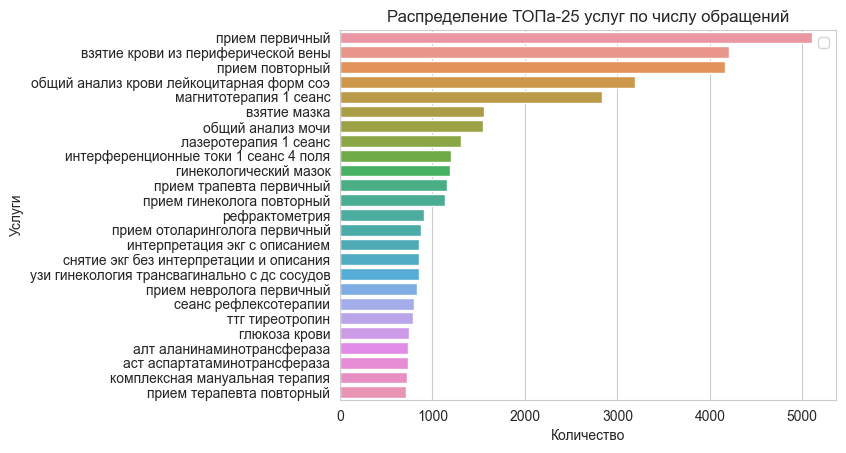

In [46]:
top25 = data.groupby('service_name').count()
top25 = top25.rename(columns={'record_id':'count'})
top25 = top25.sort_values('count', ascending = False).reset_index().head(25)
sns.barplot(x='count', y='service_name', data=top25)
plt.title('Распределение ТОПа-25 услуг по числу обращений')
plt.legend('')
plt.xlabel('Количество')
plt.ylabel('Услуги')
plt.show()

В пятёрку популярнейших услуг входят: первичный прием, взятие крови из периферической вены, прием повторный, общий анализ крови лейкоцитарная форм соэ и магнитотерапия 1 сеанс.

In [47]:
data.service_name.value_counts(normalize=True).to_frame().head(25)

proportion
service_name                                            
прием первичный                                 0.060821
взятие крови из периферической вены             0.050071
прием повторный                                 0.049583
общий анализ крови лейкоцитарная форм соэ       0.037952
магнитотерапия 1 сеанс                          0.033786
взятие мазка                                    0.018560
общий анализ мочи                               0.018440
лазеротерапия 1 сеанс                           0.015631
интерференционные токи 1 сеанс 4 поля           0.014226
гинекологический мазок                          0.014214
прием трапевта первичный                        0.013774
прием гинеколога повторный                      0.013560
рефрактометрия                                  0.010821
прием отоларинголога первичный                  0.010369
интерпретация экг с описанием                   0.010226
снятие экг без интерпретации и описания         0.010202
узи гинекология трансвагинально с дс сосудов    0.010179
прием невролога первичный                       0.009905
сеанс рефлексотерапии                           0.009548
ттг тиреотропин                                 0.009452
глюкоза крови                                   0.008845
алт аланинаминотрансфераза                      0.008714
аст аспартатаминотрансфераза                    0.008702
комплексная мануальная терапия                  0.008619
прием терапевта повторный                       0.008500

Первичные приёмы составляют более 6% от числа всех оказанных услуг клиникой.

In [48]:
data.query('service_name == "прием первичный"').describe()

record_id                   service_date  service_amount  \
count  5.109000e+03                           5109     5109.000000   
mean   3.095340e+10  2021-06-18 07:54:38.684674304     1479.454884   
min    3.026816e+10            2021-01-03 00:00:00     1470.000000   
25%    3.062088e+10            2021-04-07 00:00:00     1470.000000   
50%    3.096175e+10            2021-06-22 00:00:00     1470.000000   
75%    3.140874e+10            2021-09-03 00:00:00     1470.000000   
max    3.148607e+10            2021-10-31 00:00:00     1755.000000   
std    4.055074e+08                            NaN       24.177572   

       service_number        insured       sex_id  age_for_service_date  \
count          5109.0    5109.000000  5109.000000           5109.000000   
mean              1.0  487170.652182     1.605794             31.045606   
min               1.0  125073.000000     1.000000              0.000000   
25%               1.0  374667.000000     1.000000             25.000000   
50%               1.0  512546.000000     2.000000             32.000000   
75%               1.0  634743.000000     2.000000             39.000000   
max               1.0  716164.000000     2.000000             83.000000   
std               0.0  166805.963290     0.488727             13.683584   

             price                      month_cal      weekday        month  \
count  5109.000000                           5109  5109.000000  5109.000000   
mean   1479.454884  2021-06-03 04:23:49.007633408     2.795068     6.067332   
min    1470.000000            2021-01-01 00:00:00     0.000000     1.000000   
25%    1470.000000            2021-04-01 00:00:00     1.000000     4.000000   
50%    1470.000000            2021-06-01 00:00:00     3.000000     6.000000   
75%    1470.000000            2021-09-01 00:00:00     4.000000     9.000000   
max    1755.000000            2021-10-01 00:00:00     6.000000    10.000000   
std      24.177572                            NaN     1.956578     2.789777   

         year  
count  5109.0  
mean   2021.0  
min    2021.0  
25%    2021.0  
50%    2021.0  
75%    2021.0  
max    2021.0  
std       0.0

`Первичный приём` осуществлялся по примерно одинаковой стоимости в количестве 1 приема для мужчин и женщин от 0 до 83 лет с понедельника по воскресенье с января по октябрь в 2021 году.

In [49]:
data.query('service_name == "взятие крови из периферической вены"').describe()

record_id                   service_date  service_amount  \
count  4.206000e+03                           4206     4206.000000   
mean   3.180089e+10  2021-12-03 03:48:21.569186816      167.932715   
min    3.026816e+10            2021-01-03 00:00:00      158.000000   
25%    3.111198e+10            2021-07-22 00:00:00      158.000000   
50%    3.181413e+10            2021-12-16 00:00:00      170.000000   
75%    3.251111e+10            2022-04-21 00:00:00      170.000000   
max    3.317815e+10            2022-08-31 00:00:00      561.000000   
std    8.279532e+08                            NaN       15.503657   

       service_number       insured       sex_id  age_for_service_date  \
count     4206.000000  4.206000e+03  4206.000000           4206.000000   
mean         1.004042  6.523051e+05     1.620780             32.678554   
min          1.000000  1.250730e+05     1.000000              0.000000   
25%          1.000000  4.909815e+05     1.000000             26.000000   
50%          1.000000  6.362170e+05     2.000000             34.000000   
75%          1.000000  8.226990e+05     2.000000             40.000000   
max          3.000000  1.306795e+06     2.000000             75.000000   
std          0.077000  2.639859e+05     0.485251             12.933723   

             price                      month_cal      weekday        month  \
count  4206.000000                           4206  4206.000000  4206.000000   
mean    167.257965  2021-11-18 03:03:10.014265344     2.980266     5.819068   
min     158.000000            2021-01-01 00:00:00     0.000000     1.000000   
25%     158.000000            2021-07-01 00:00:00     1.000000     3.000000   
50%     170.000000            2021-12-01 00:00:00     3.000000     6.000000   
75%     170.000000            2022-04-01 00:00:00     5.000000     8.000000   
max     187.000000            2022-08-01 00:00:00     6.000000    12.000000   
std       8.356206                            NaN     1.959844     3.120844   

              year  
count  4206.000000  
mean   2021.480742  
min    2021.000000  
25%    2021.000000  
50%    2021.000000  
75%    2022.000000  
max    2022.000000  
std       0.499688

А , вот, у услуги `взятие крови из периферической вены` сильный размах стоимости, связанный с различным количеством услуг в наборе. Сама цена услуги имеет не сильный размах. Такая услуга осуществлялась в любой день недели, в любой месяц и год. Она оказывалась мужчинам и женщинам от 0 до 75 лет с 3 января 2021 года по 31 августа 2022 года.

In [50]:
data.query('service_name == "прием повторный"').describe()

record_id                   service_date  service_amount  \
count  4.165000e+03                           4165     4165.000000   
mean   3.095468e+10  2021-06-18 18:16:40.912365056     1322.201441   
min    3.026816e+10            2021-01-03 00:00:00     1313.000000   
25%    3.062092e+10            2021-04-10 00:00:00     1313.000000   
50%    3.096172e+10            2021-06-17 00:00:00     1313.000000   
75%    3.140874e+10            2021-09-05 00:00:00     1313.000000   
max    3.148607e+10            2021-10-31 00:00:00     1380.000000   
std    4.013561e+08                            NaN       23.064209   

       service_number        insured       sex_id  age_for_service_date  \
count          4165.0    4165.000000  4165.000000           4165.000000   
mean              1.0  476143.437215     1.627131             32.846819   
min               1.0  125073.000000     1.000000              0.000000   
25%               1.0  362958.000000     1.000000             26.000000   
50%               1.0  512474.000000     2.000000             33.000000   
75%               1.0  596552.000000     2.000000             40.000000   
max               1.0  716164.000000     2.000000             75.000000   
std               0.0  165988.366213     0.483626             13.121799   

             price                      month_cal      weekday        month  \
count  4165.000000                           4165  4165.000000  4165.000000   
mean   1322.201441  2021-06-03 14:31:15.630252032     2.840576     6.081152   
min    1313.000000            2021-01-01 00:00:00     0.000000     1.000000   
25%    1313.000000            2021-04-01 00:00:00     1.000000     4.000000   
50%    1313.000000            2021-06-01 00:00:00     3.000000     6.000000   
75%    1313.000000            2021-09-01 00:00:00     4.000000     9.000000   
max    1380.000000            2021-10-01 00:00:00     6.000000    10.000000   
std      23.064209                            NaN     1.934453     2.758472   

         year  
count  4165.0  
mean   2021.0  
min    2021.0  
25%    2021.0  
50%    2021.0  
75%    2021.0  
max    2021.0  
std       0.0

Судя по максимальной дате упоминания повторного приема и первичного приема, такая классификация перестала употребляться в конце октября 2021 года. После этого, вероятно, начали добавлять специалиста, к которому была запись на прием.

Повторный прием осуществлялся с 3 января 2021 года по 31 октября 2021 года для женщин и мужчин от 0 до 75 лет в любой день недели, месяц. Размах цены здесь очень маленький.

In [51]:
data.query('is_priem == True').describe()

record_id                   service_date  service_amount  \
count  2.502600e+04                          25026    25026.000000   
mean   3.185231e+10  2021-12-13 05:08:11.105250560     1483.851275   
min    3.026816e+10            2021-01-03 00:00:00     1050.000000   
25%    3.124929e+10            2021-08-05 00:00:00     1380.000000   
50%    3.199631e+10            2022-01-10 00:00:00     1470.000000   
75%    3.263120e+10            2022-05-02 00:00:00     1540.000000   
max    3.317815e+10            2022-08-31 00:00:00     5510.000000   
std    8.314978e+08                            NaN      274.951119   

       service_number       insured        sex_id  age_for_service_date  \
count         25026.0  2.502600e+04  25026.000000          25026.000000   
mean              1.0  6.597569e+05      1.622872             32.590985   
min               1.0  1.250730e+05      1.000000              0.000000   
25%               1.0  5.096840e+05      1.000000             26.000000   
50%               1.0  6.519500e+05      2.000000             33.000000   
75%               1.0  8.423540e+05      2.000000             40.000000   
max               1.0  1.306795e+06      2.000000             83.000000   
std               0.0  2.661909e+05      0.484677             12.839106   

              price                      month_cal       weekday  \
count  25026.000000                          25026  25026.000000   
mean    1483.851275  2021-11-28 02:48:14.845360896      2.771398   
min     1050.000000            2021-01-01 00:00:00      0.000000   
25%     1380.000000            2021-08-01 00:00:00      1.000000   
50%     1470.000000            2022-01-01 00:00:00      3.000000   
75%     1540.000000            2022-05-01 00:00:00      4.000000   
max     5510.000000            2022-08-01 00:00:00      6.000000   
std      274.951119                            NaN      1.934731   

              month          year  
count  25026.000000  25026.000000  
mean       5.805682   2021.509270  
min        1.000000   2021.000000  
25%        3.000000   2021.000000  
50%        5.000000   2022.000000  
75%        8.000000   2022.000000  
max       12.000000   2022.000000  
std        3.086020      0.499924

Более объективно оценивать все приемы (из-за смены порядка фиксирования названия услуги). Стоимость услуги как и цена имеют очень сильный размах (от 1050 до 5510 рублей). Такая услуга оказывалась мужчинам и женщинам от 0 до 83 лет в любой день недели, месяц и год.

categories
другое          28177
консультация    25429
диагностика     15398
лечение         14996
Name: count, dtype: int64

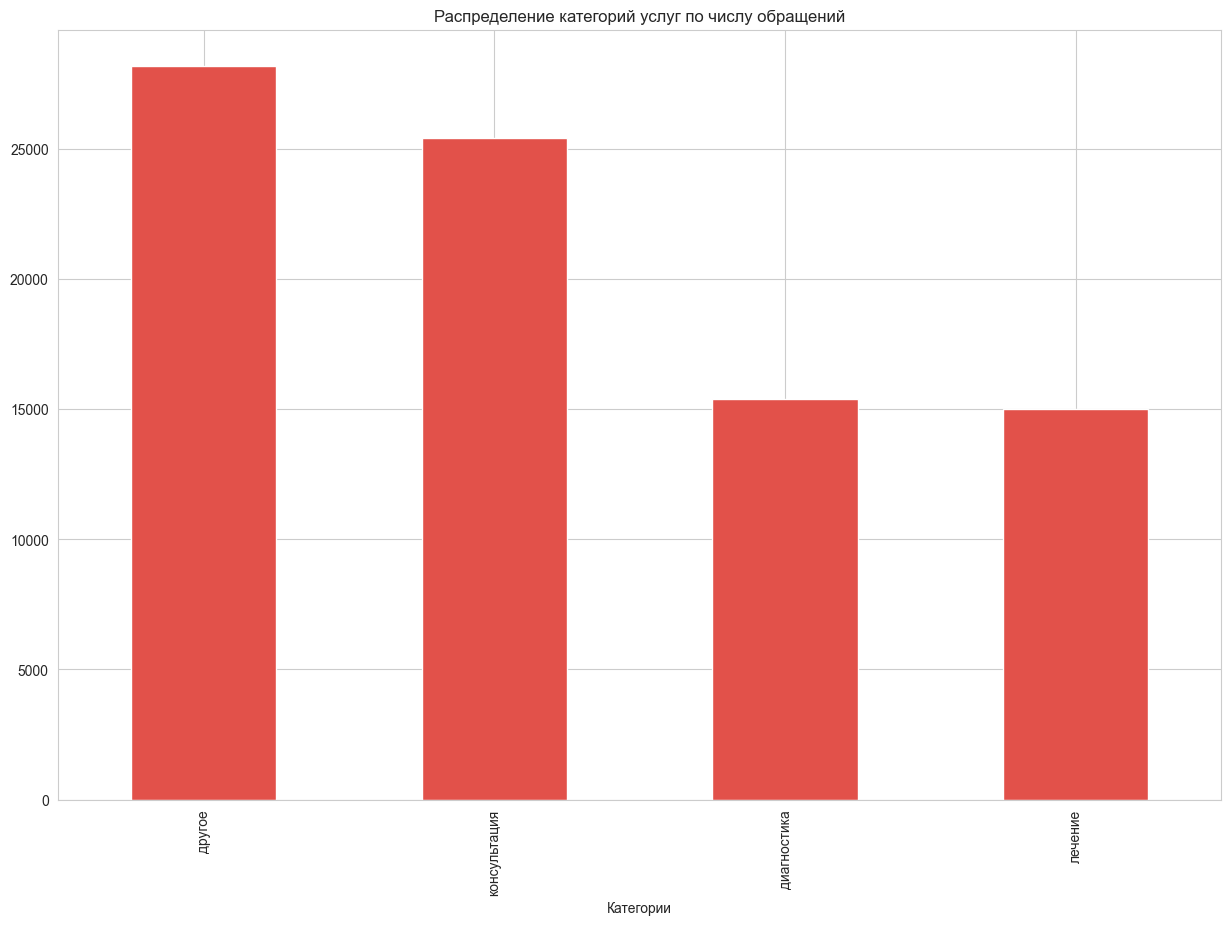

In [52]:
cat = data['categories'].value_counts()
display(cat)
cat.plot(kind='bar', grid=True, figsize=(15,10))
plt.title('Распределение категорий услуг по числу обращений')
plt.xlabel('Категории')
plt.show()

Больше всего услуг в категории `другое`, далее идут консультации и диагностика, а меньше всего услуг по лечению.

categories    диагностика   другое  консультация  лечение
service_date                                             
2021-01-03         6300.0   8586.0       12288.0  10179.0
2021-01-04         7961.0   5079.0       22999.0  22203.0
2021-01-05        24434.0  16231.0       26517.0  28301.0
2021-01-06         6501.0  11957.0       14072.0  25206.0
2021-01-07         5473.0   5124.0       20373.0  22803.0
...                   ...      ...           ...      ...
2022-08-27        26091.0  16127.0       29590.0  11550.0
2022-08-28        10020.0   6903.0       31590.0  12940.0
2022-08-29        39790.0  30873.0       56960.0  26780.0
2022-08-30        41236.0  15788.0       54850.0  17835.0
2022-08-31        42076.0  32799.0       66485.0  38700.0

[602 rows x 4 columns]

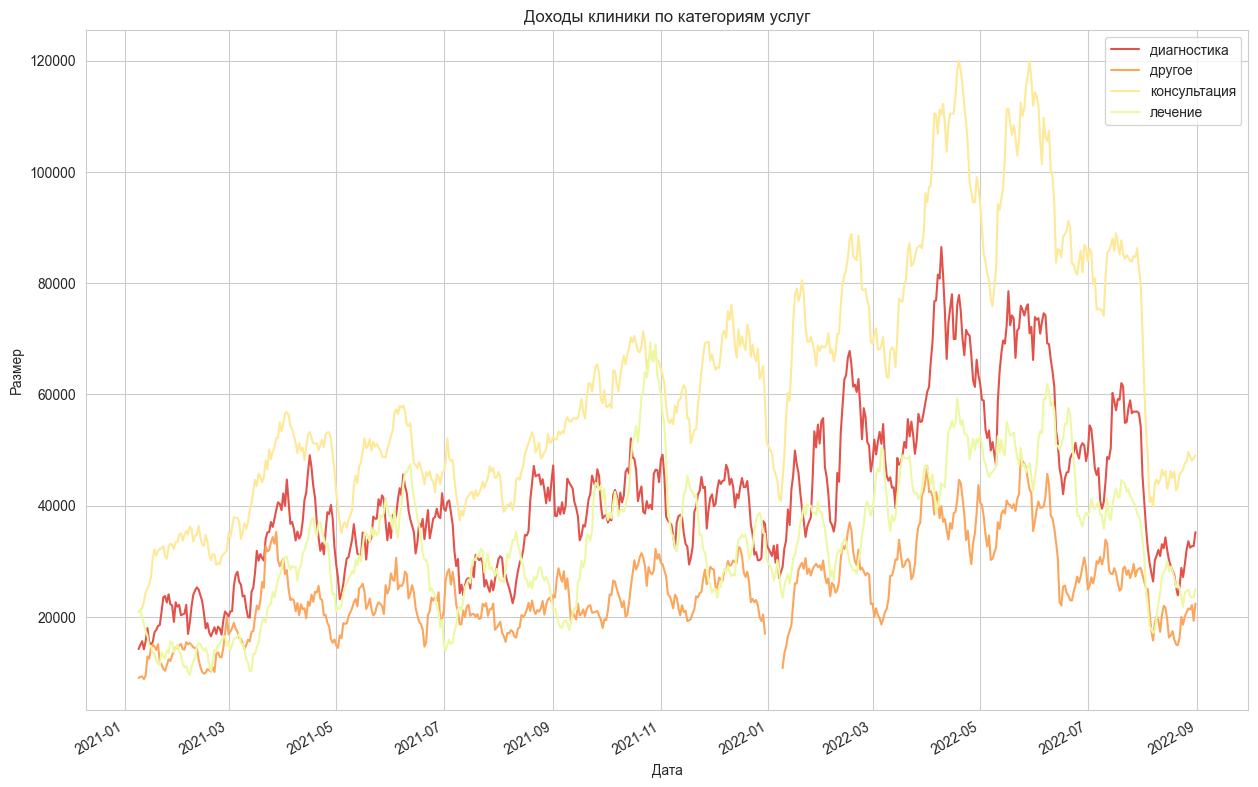

In [53]:
service_income = data.pivot_table(index='service_date',
                columns='categories',
                values='service_amount',
                aggfunc='sum')
display(service_income)
filter_data(service_income, 7).plot(grid=True, figsize=(15, 10))
plt.legend()
plt.title('Доходы клиники по категориям услуг')
plt.xlabel('Дата')
plt.ylabel('Размер')
plt.show()

Услуг из категории `другое` много, но доходы по ним меньше, чем по услугам из других категорий. Менее популярные `консультации` опережают остальные категории по доходам. Часть таблицы. расположенная выше, подтверждает примерное распределение доходов, отражённое на графике.

categories  диагностика   другое  консультация   лечение
year                                                    
2021           12289662  7734527      18017550  10552156
2022           12674770  7152811      19435480   9698098

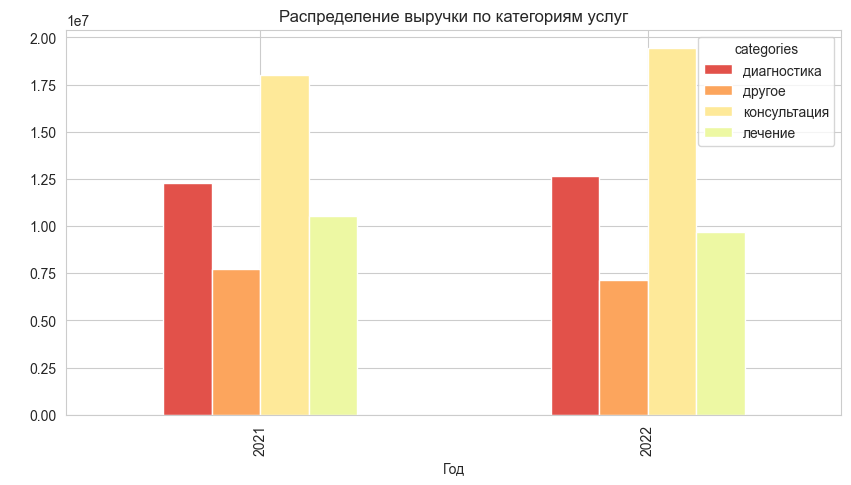

In [54]:
categ_pivot = data.pivot_table(index='year',
                columns='categories',
                values='service_amount',
                aggfunc='sum')
display(categ_pivot)
categ_pivot.plot(kind='bar', figsize=(10,5))
plt.title('Распределение выручки по категориям услуг')
plt.xlabel('Год')
plt.ylabel(' ')
plt.show()

Несмотря на неполноту данных за 2022 год, распределение выручки по категориям не меняется в 2022 году, по сравнению с 2021 годом. `Консультации` и `диагностика` даже успели принести больше денег, чем в 2021 году.

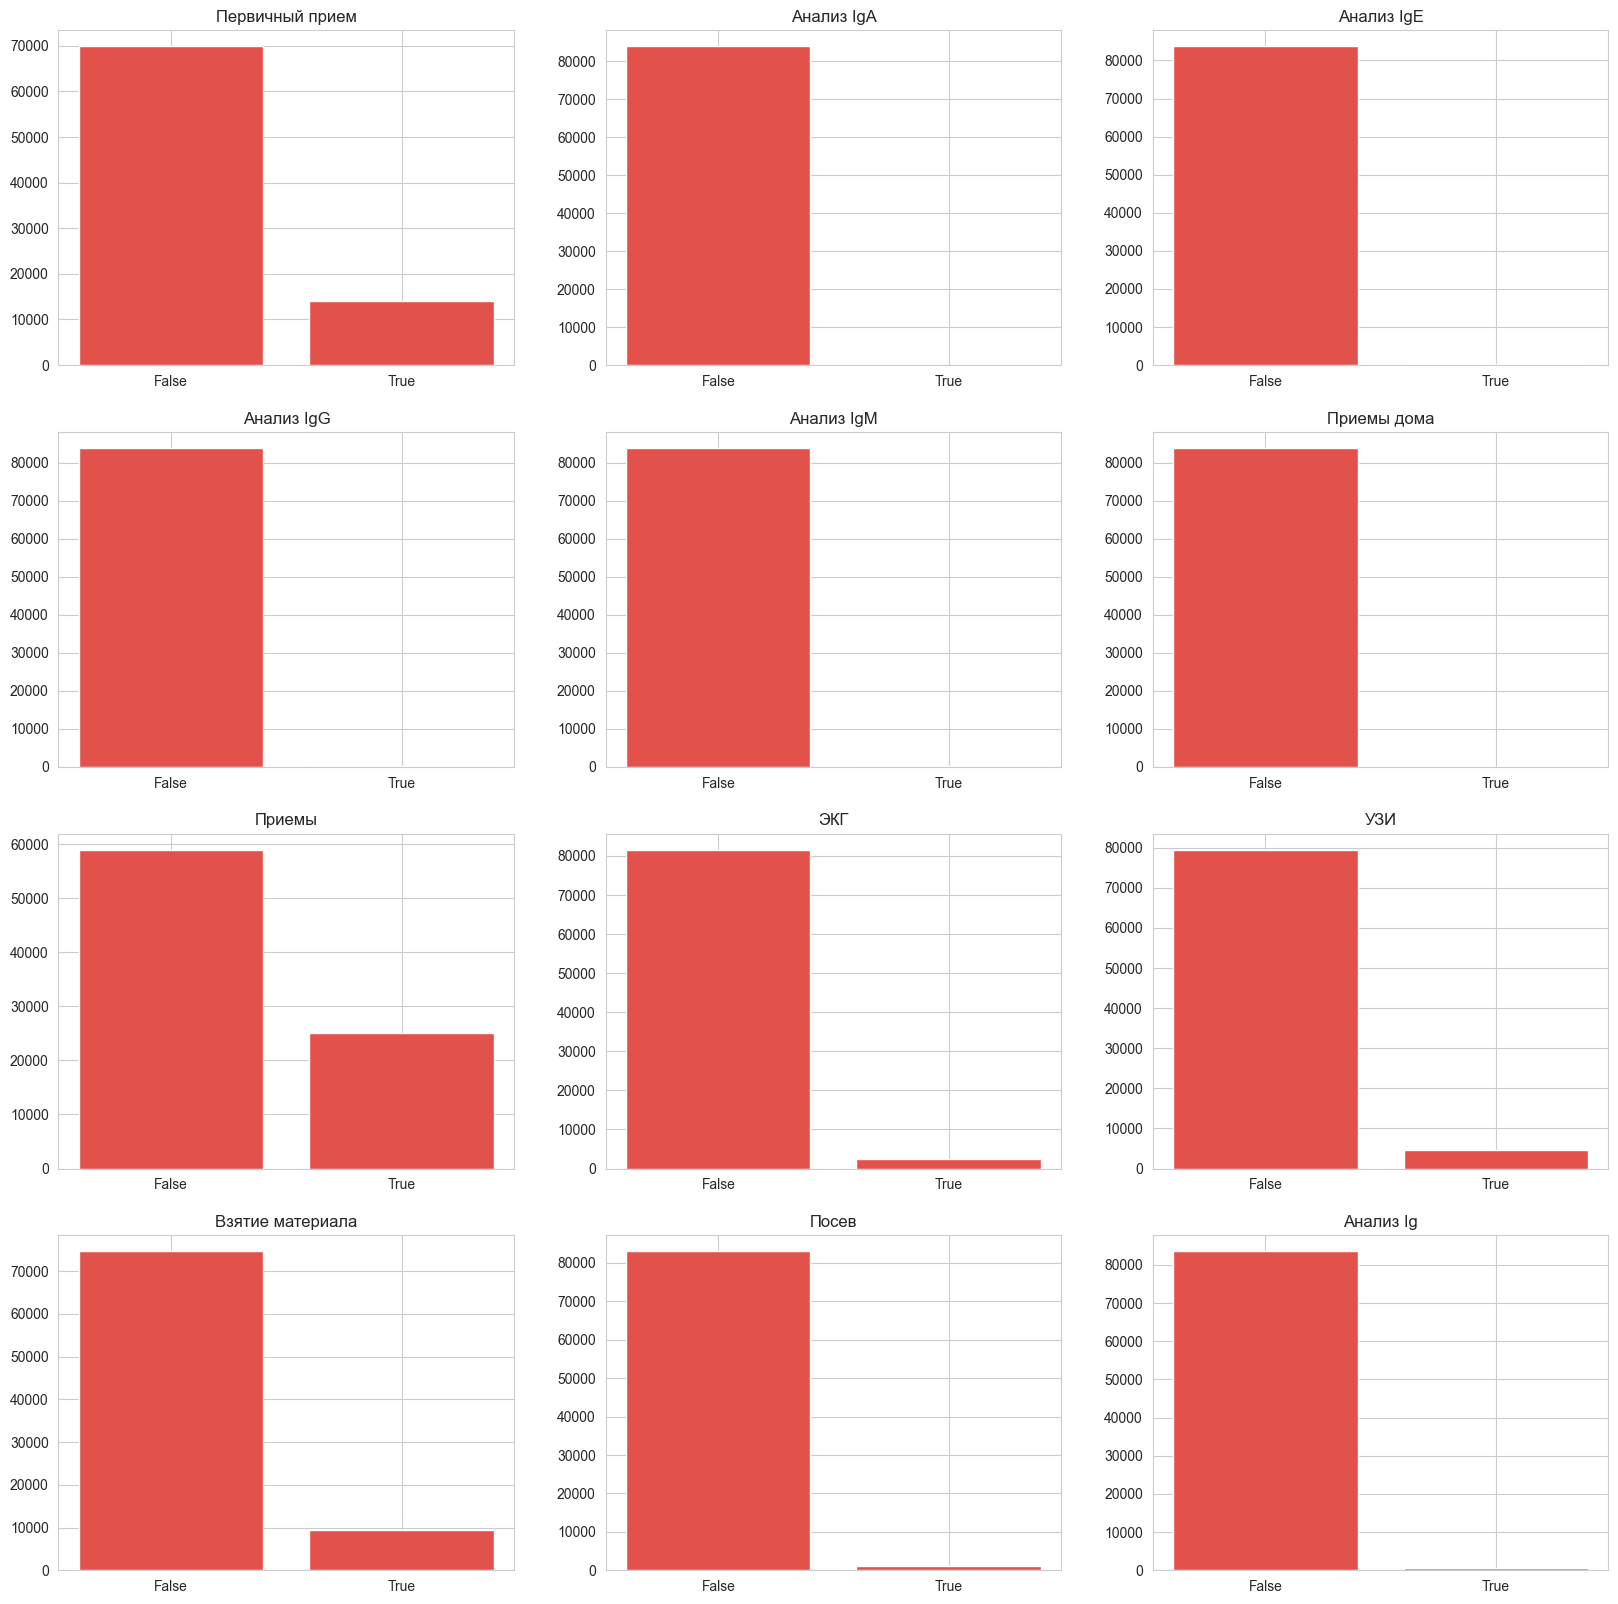

is_first
False    69911
True     14089
Name: count, dtype: int64

is_home
False    83933
True        67
Name: count, dtype: int64

is_priem
False    58974
True     25026
Name: count, dtype: int64

is_ekg
False    81596
True      2404
Name: count, dtype: int64

is_uzi
False    79488
True      4512
Name: count, dtype: int64

is_vzyatie_biomaterial
False    74629
True      9371
Name: count, dtype: int64

is_posev
False    82995
True      1005
Name: count, dtype: int64

is_ig
False    83496
True       504
Name: count, dtype: int64

In [55]:
fig, ax = plt.subplots(nrows= 4, ncols= 3, figsize=(20,20))

ax[0,0].bar(["False", "True"], data['is_first'].value_counts())
ax[0,0].set_title('Первичный прием')
ax[0,1].bar(["False", "True"], data['is_iga'].value_counts())
ax[0,1].set_title('Анализ IgA')
ax[0,2].bar(["False", "True"], data['is_ige'].value_counts())
ax[0,2].set_title('Анализ IgE')
ax[1,0].bar(["False", "True"], data['is_igg'].value_counts())
ax[1,0].set_title('Анализ IgG')
ax[1,1].bar(["False", "True"], data['is_igm'].value_counts())
ax[1,1].set_title('Анализ IgM')
ax[1,2].bar(["False", "True"], data['is_home'].value_counts())
ax[1,2].set_title('Приемы дома')
ax[2,0].bar(["False", "True"], data['is_priem'].value_counts())
ax[2,0].set_title('Приемы')
ax[2,1].bar(["False", "True"], data['is_ekg'].value_counts())
ax[2,1].set_title('ЭКГ')
ax[2,2].bar(["False", "True"], data['is_uzi'].value_counts())
ax[2,2].set_title('УЗИ')
ax[3,0].bar(["False", "True"], data['is_vzyatie_biomaterial'].value_counts())
ax[3,0].set_title('Взятие материала')
ax[3,1].bar(["False", "True"], data['is_posev'].value_counts())
ax[3,1].set_title('Посев')
ax[3,2].bar(["False", "True"], data['is_ig'].value_counts())
ax[3,2].set_title('Анализ Ig')
plt.show()

display(data['is_first'].value_counts())
display(data['is_home'].value_counts())
display(data['is_priem'].value_counts())
display(data['is_ekg'].value_counts())
display(data['is_uzi'].value_counts())
display(data['is_vzyatie_biomaterial'].value_counts())
display(data['is_posev'].value_counts())
display(data['is_ig'].value_counts())

Исходя из точечного анализа услуг, можно сделать вывод, что самые популярные категории из представленных: `прием`, `первичный прием` и `взятие материала`.

#### <a id='toc1_4_1_1_'></a>[Динамика доходов клиники](#toc0_)

year        2021       2022
month                      
1      2163556.0  4792530.0
2      2250655.0  5289785.0
3      3723099.0  6447890.0
4      4189228.0  8034000.0
5      4086463.0  7586400.0
6      4281485.0  6879580.0
7      3691602.0  6214515.0
8      4089943.0  3716459.0
9      4538454.0        NaN
10     5833320.0        NaN
11     4743240.0        NaN
12     5002850.0        NaN

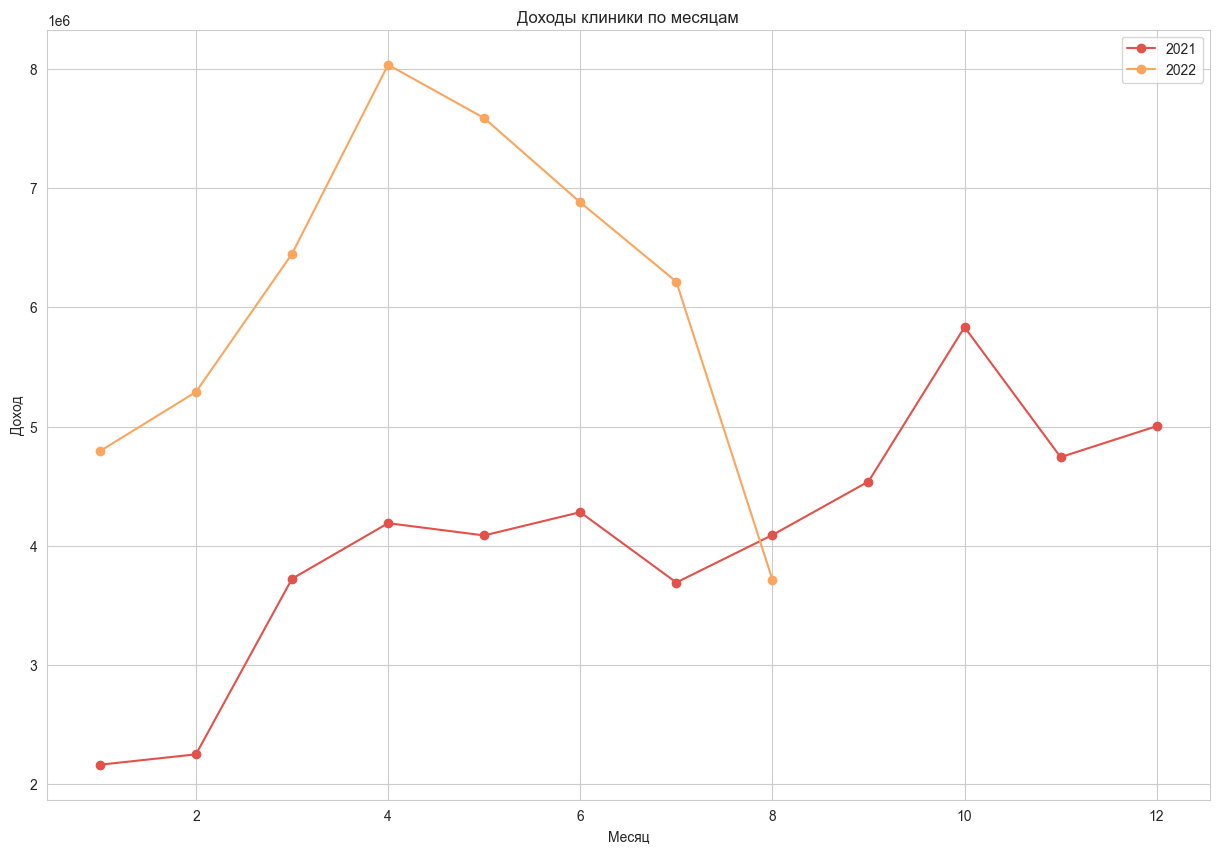

year        2021       2022    income  share2021  share2022
month                                                      
1      2163556.0  4792530.0  97555054   2.217780   4.912641
2      2250655.0  5289785.0  97555054   2.307061   5.422359
3      3723099.0  6447890.0  97555054   3.816408   6.609488
4      4189228.0  8034000.0  97555054   4.294219   8.235350
5      4086463.0  7586400.0  97555054   4.188879   7.776532
6      4281485.0  6879580.0  97555054   4.388789   7.051998
7      3691602.0  6214515.0  97555054   3.784122   6.370265
8      4089943.0  3716459.0  97555054   4.192446   3.809602
9      4538454.0        NaN  97555054   4.652198        NaN
10     5833320.0        NaN  97555054   5.979516        NaN
11     4743240.0        NaN  97555054   4.862116        NaN
12     5002850.0        NaN  97555054   5.128233        NaN

In [56]:
month_income = data.pivot_table(index='month',
                columns='year',
                values='service_amount',
                aggfunc='sum')
display(month_income)
month_income.plot(grid=True, figsize=(15, 10), style='o-')
plt.legend()
plt.title('Доходы клиники по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Доход')
plt.show()
month_income['income'] = data['service_amount'].sum()
month_income['share2021'] = month_income[2021] / month_income['income']*100
month_income['share2022'] = month_income[2022] / month_income['income']*100
month_income

Наблюдается общая тенденция к возрастанию выручки за месяц с небольшими откатами, а также тенденцией к снижению с апреля 2022 года по август 2022 года.

В последней таблице были расчитаны доли месячного дохода клиники в итоговой сумме доходов за весь анализируемый период. В апреле 2022 года клиники получила почти 8,3% от всего дохода за анализируемый период, но к августу доля снизилась до 3,8%.

year        2021     2022
weekday                  
0        7117455  7359848
1        7296085  7163130
2        7876297  8710356
3        7097109  7034076
4        7315226  7339286
5        6596816  6495612
6        5294907  4858851

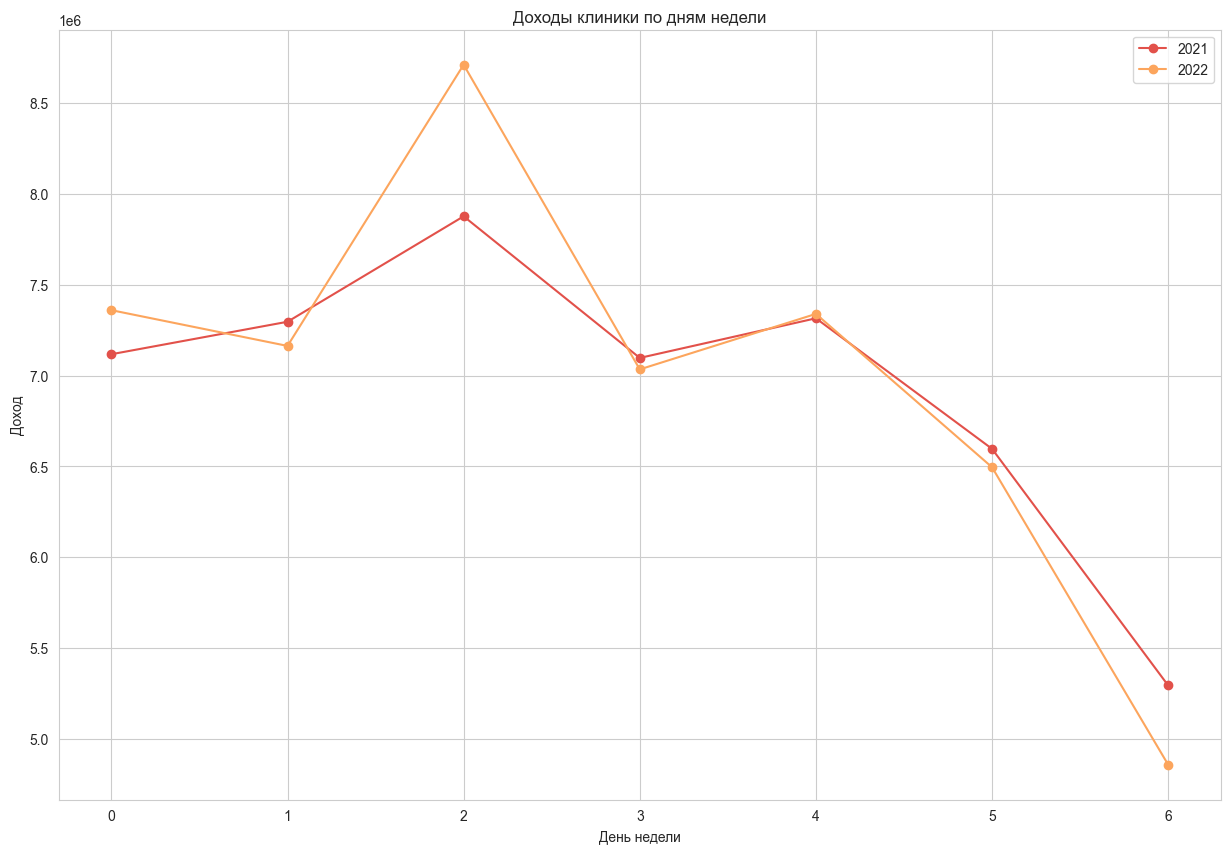

In [57]:
week_income = data.pivot_table(index='weekday',
                columns='year',
                values='service_amount',
                aggfunc='sum')
display(week_income)
week_income.plot(grid=True, figsize=(15, 10), style='o-')
plt.legend()
plt.title('Доходы клиники по дням недели')
plt.xlabel('День недели')
plt.ylabel('Доход')
plt.show()

В среду клиенты клиники приносят ей самые большие доходы. В среднем, минимальные доходы получает клиника по выходным.

sex_category  женщины  мужчины
month                         
1             4051780  2904306
2             4544159  2996281
3             6197580  3973409
4             7906439  4316789
5             7897711  3775152
6             7135681  4025384
7             5730792  4175325
8             4832238  2974164
9             2709258  1829196
10            3450150  2383170
11            3025000  1718240
12            2697100  2305750

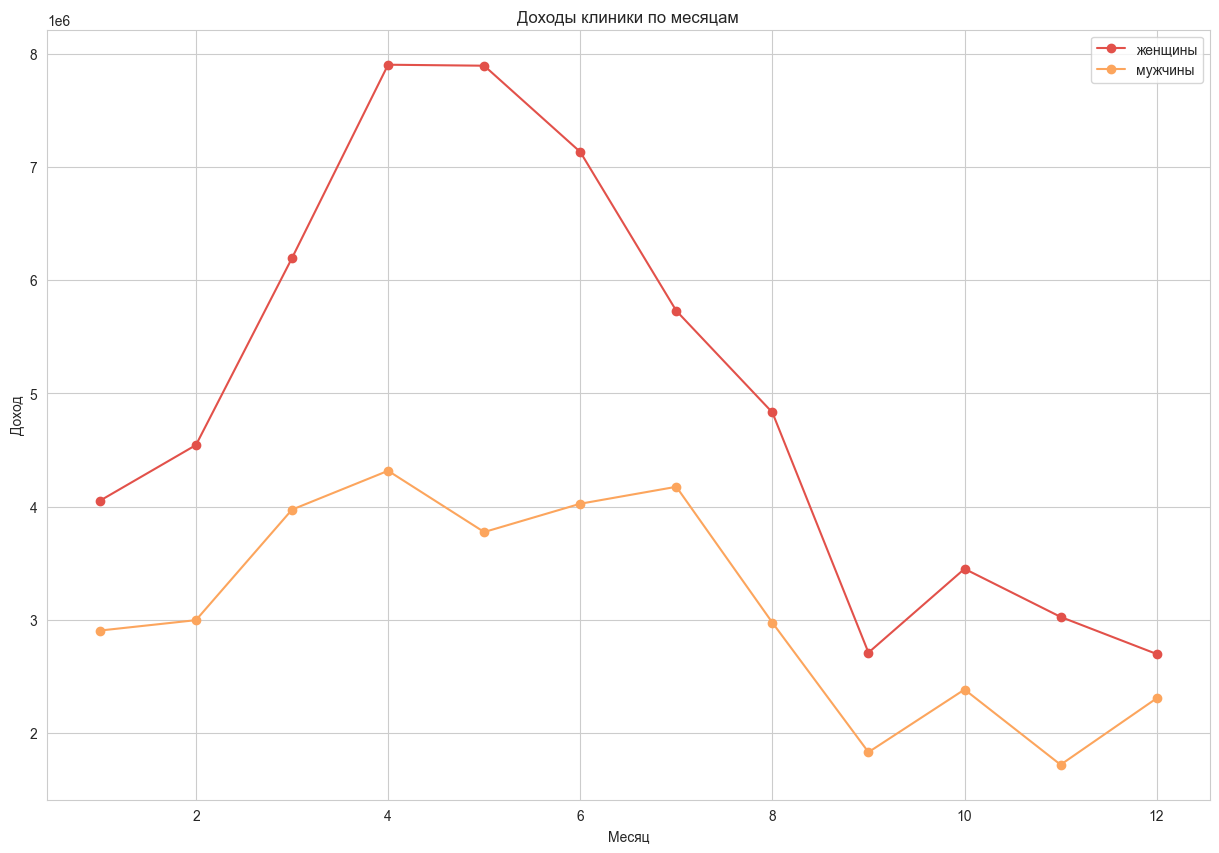

In [58]:
gender_income = data.pivot_table(index='month',
                columns='sex_category',
                values='service_amount',
                aggfunc='sum')
display(gender_income)
gender_income.plot(grid=True, figsize=(15, 10), style='o-')
plt.legend()
plt.title('Доходы клиники по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Доход')
plt.show()

Женщины в каждом месяце приносили клинике больше доходов (в первую очередь, за счёт своего количества).

sex_category  женщины  мужчины
weekday                       
0             8954411  5522892
1             9117991  5341224
2             9816948  6769705
3             8855595  5275590
4             9007455  5647057
5             8087371  5005057
6             6338117  3815641

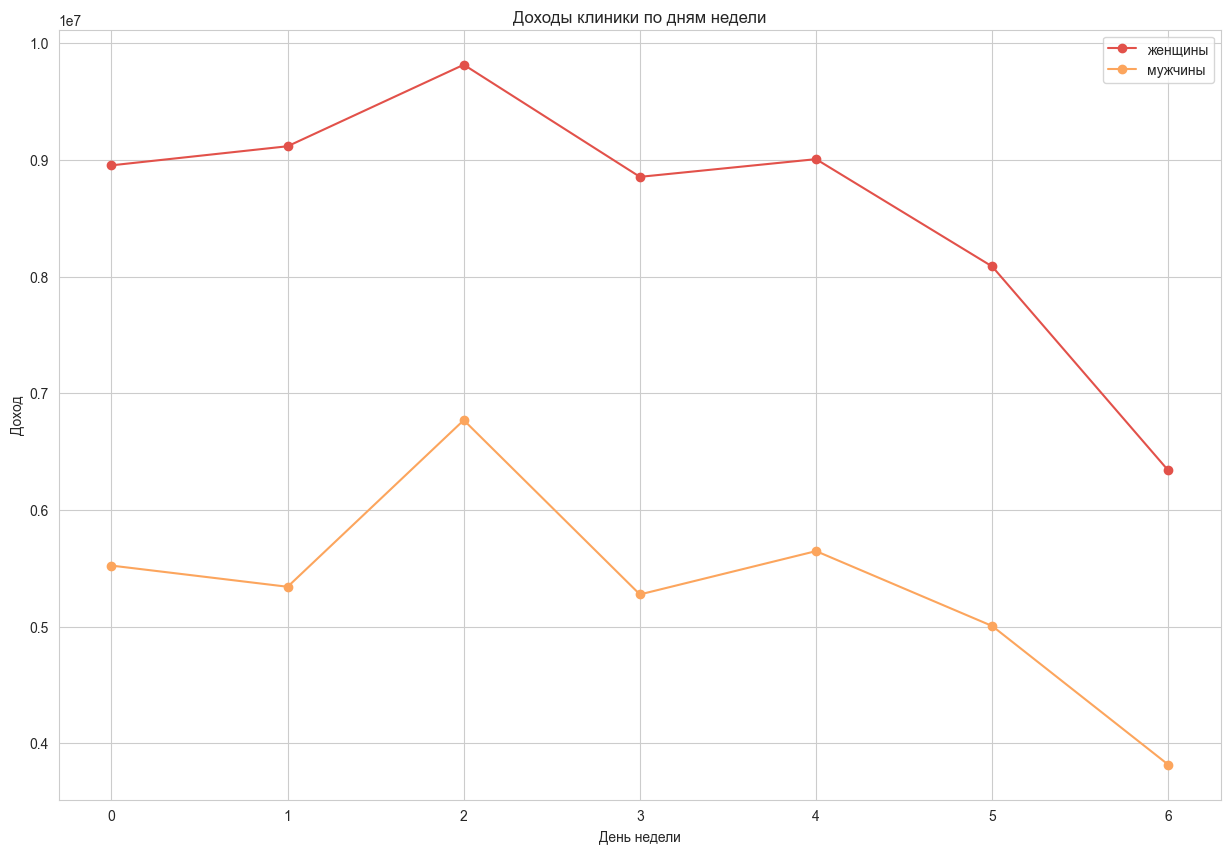

In [59]:
gender_income_w = data.pivot_table(index='weekday',
                columns='sex_category',
                values='service_amount',
                aggfunc='sum')
display(gender_income_w)
gender_income_w.plot(grid=True, figsize=(15, 10), style='o-')
plt.legend()
plt.title('Доходы клиники по дням недели')
plt.xlabel('День недели')
plt.ylabel('Доход')
plt.show()

Аналогично с днями недели, лидируют женщины.

#### <a id='toc1_4_1_2_'></a>[Динамика цен в клинике](#toc0_)

price  service_amount
service_date                          
2021-01-03     37353.0           37353
2021-01-04     57958.0           58242
2021-01-05     95483.0           95483
2021-01-06     57736.0           57736
2021-01-07     53432.0           53773
...                ...             ...
2022-08-27     83358.0           83358
2022-08-28     61453.0           61453
2022-08-29    153611.0          154403
2022-08-30    126737.0          129709
2022-08-31    179664.0          180060

[602 rows x 2 columns]

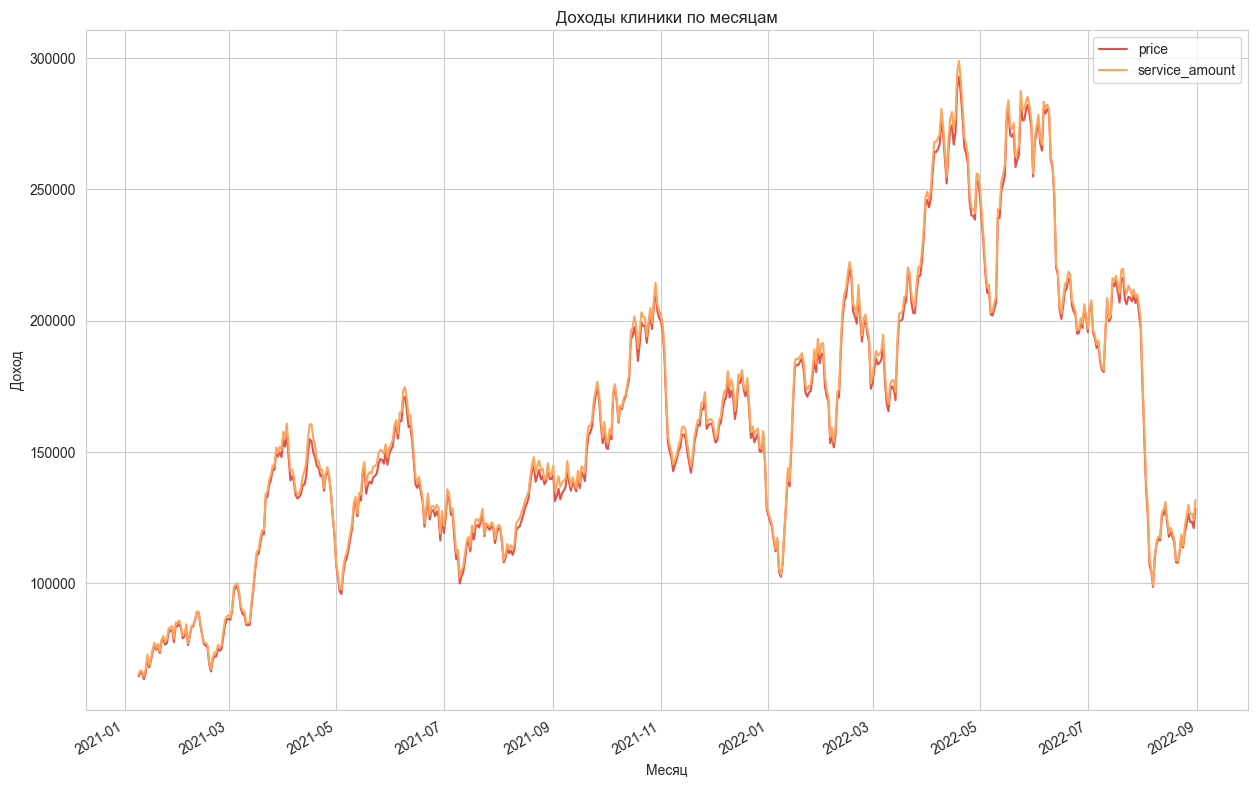

In [60]:
price_income = data.pivot_table(index='service_date',
                values=['service_amount', 'price'],
                aggfunc='sum')
display(price_income)
filter_data(price_income, 7).plot(grid=True, figsize=(15, 10))
plt.legend()
plt.title('Доходы клиники по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Доход')
plt.show()

Динамика стоимости услуг в клинике почти полностью повторяет динамику цен оказанных услуг. Сложно судить об изменении цен на конкретные услуги, поэтому график не доказывает гипотезу о влиянии изменения цен на изменение доходов клиники.

#### <a id='toc1_4_1_3_'></a>[Статистика клиентов клиники](#toc0_)

sex_category
женщины    2555
мужчины    1932
Name: insured, dtype: int64

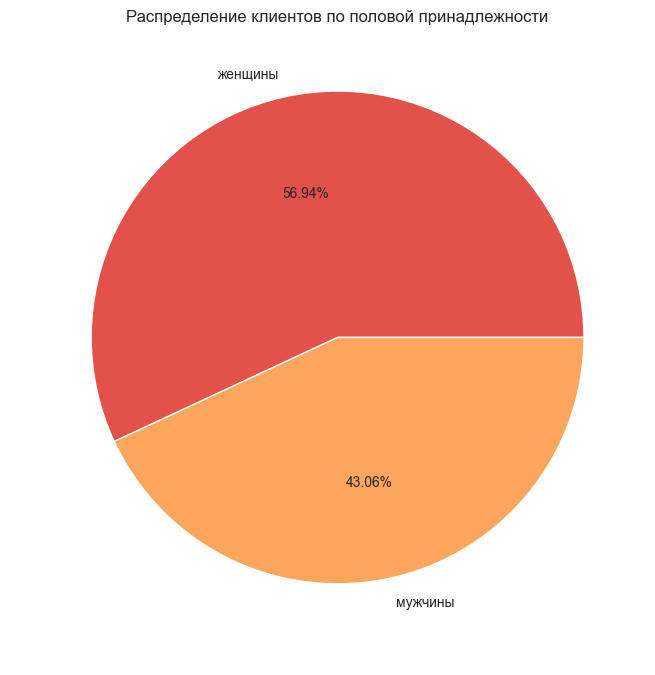

In [61]:
gender = data.groupby('sex_category')['insured'].nunique()
display(gender)
gender.plot(y='count', kind='pie', figsize=(8, 8), autopct='%1.2f%%')
plt.title('Распределение клиентов по половой принадлежности')
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

sex_category
женщины    51921
мужчины    32079
Name: count, dtype: int64

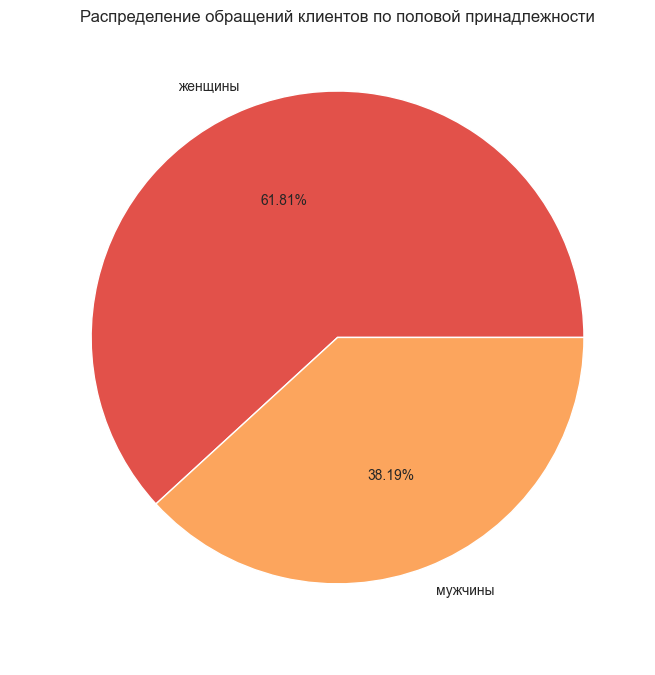

In [62]:
gender_visit = data.sex_category.value_counts()
display(gender_visit)
gender_visit.plot(y='count', kind='pie', figsize=(8, 8), autopct='%1.2f%%')
plt.title('Распределение обращений клиентов по половой принадлежности')
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

In [63]:
gd = data.groupby('sex_category').agg({'service_amount':['mean', 'median']})
gd


service_amount        
                       mean  median
sex_category                       
женщины         1159.027908  1134.0
мужчины         1165.159949  1140.0

Женщин не просто больше как клиентов клиники, но они ещё более часто обращаются в клинику по различным вопросам.

Исходя из обращений, средние чеки мужчин и женщин выше, чем медианные. Это говорит о выбросах с высокими чеками. Кроме того, у мужчин средние и медианные чеки выше, чем у женщин.

sex_category          женщины  мужчины
age_for_service_date                  
0                       185.0    213.0
1                       259.0    126.0
2                       235.0    282.0
3                       425.0    251.0
4                       290.0    230.0
...                       ...      ...
71                        NaN      1.0
72                        2.0      NaN
74                        NaN      1.0
75                       48.0      NaN
83                        NaN      1.0

[76 rows x 2 columns]

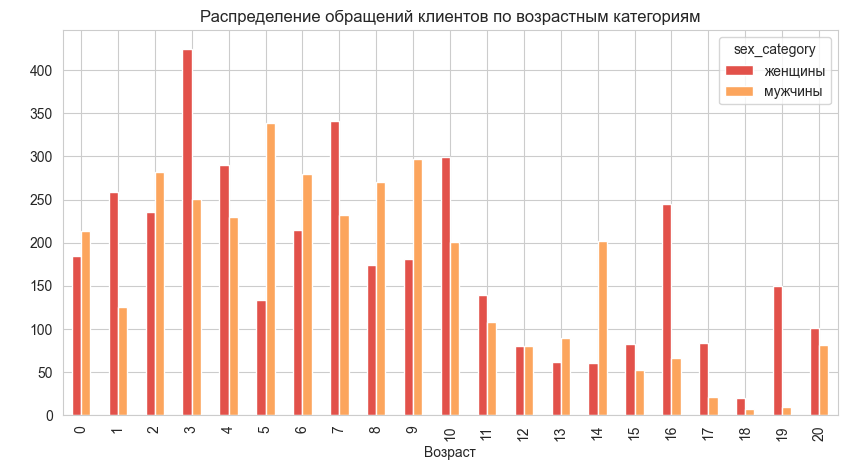

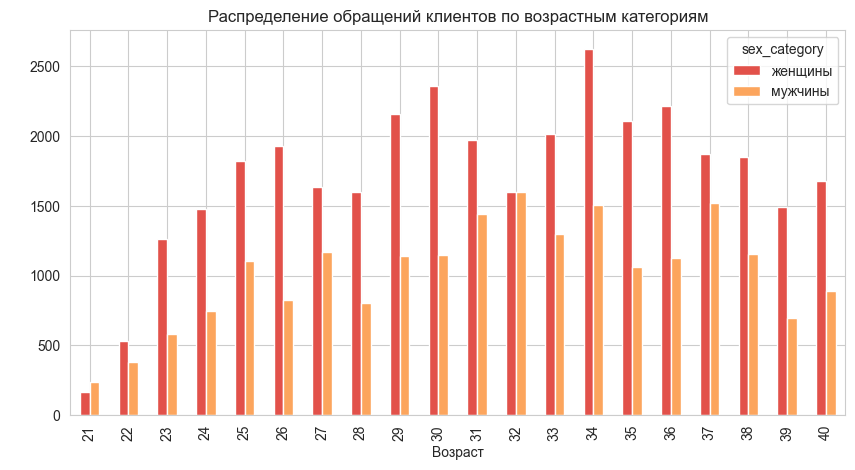

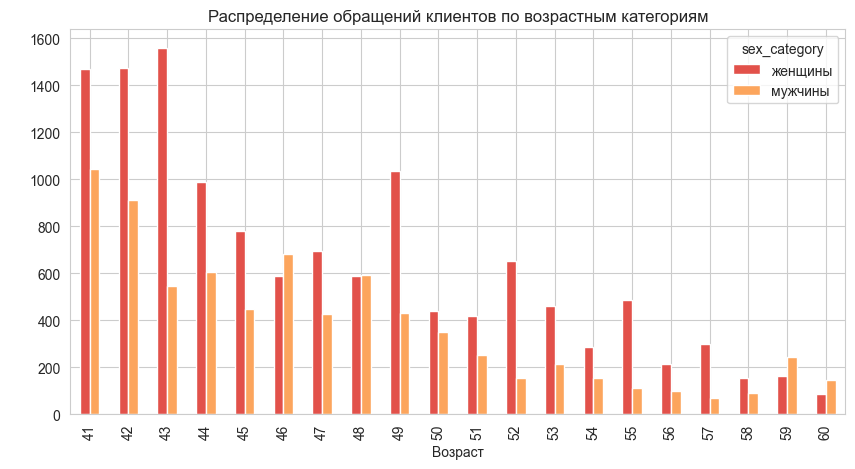

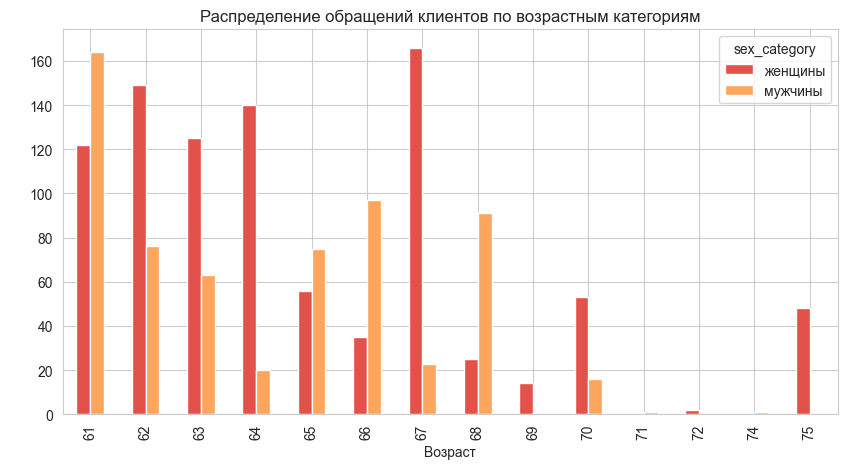

In [64]:
age_gender_pivot = data.pivot_table(index='age_for_service_date',
                columns='sex_category',
                values='insured',
                aggfunc='count')
display(age_gender_pivot)
age_gender_pivot.query('age_for_service_date < 21').plot(kind='bar', figsize=(10,5))
plt.title('Распределение обращений клиентов по возрастным категориям')
plt.xlabel('Возраст')
plt.ylabel(' ')
plt.show()
age_gender_pivot.query('age_for_service_date < 41 & age_for_service_date > 20').plot(kind='bar', figsize=(10,5))
plt.title('Распределение обращений клиентов по возрастным категориям')
plt.xlabel('Возраст')
plt.ylabel(' ')
plt.show()
age_gender_pivot.query('age_for_service_date < 61 & age_for_service_date > 40').plot(kind='bar', figsize=(10,5))
plt.title('Распределение обращений клиентов по возрастным категориям')
plt.xlabel('Возраст')
plt.ylabel(' ')
plt.show()
age_gender_pivot.query('age_for_service_date < 83 & age_for_service_date > 60').plot(kind='bar', figsize=(10,5))
plt.title('Распределение обращений клиентов по возрастным категориям')
plt.xlabel('Возраст')
plt.ylabel(' ')
plt.show()

Самые частые посещения врачей зафиксированы у женщин от 29 до 40 лет. В большинстве возрастных групп по обращениям преобладают женщины.

In [65]:
insured_pivot_gender = data.pivot_table(index='service_date',
                columns='sex_category',
                values='insured',
                aggfunc='count')
display(insured_pivot_gender)

sex_category  женщины  мужчины
service_date                  
2021-01-03         42        6
2021-01-04         36       15
2021-01-05         47       54
2021-01-06         20       42
2021-01-07         27       21
...               ...      ...
2022-08-27         52       27
2022-08-28         24       24
2022-08-29        102       31
2022-08-30         69       31
2022-08-31         91       56

[602 rows x 2 columns]

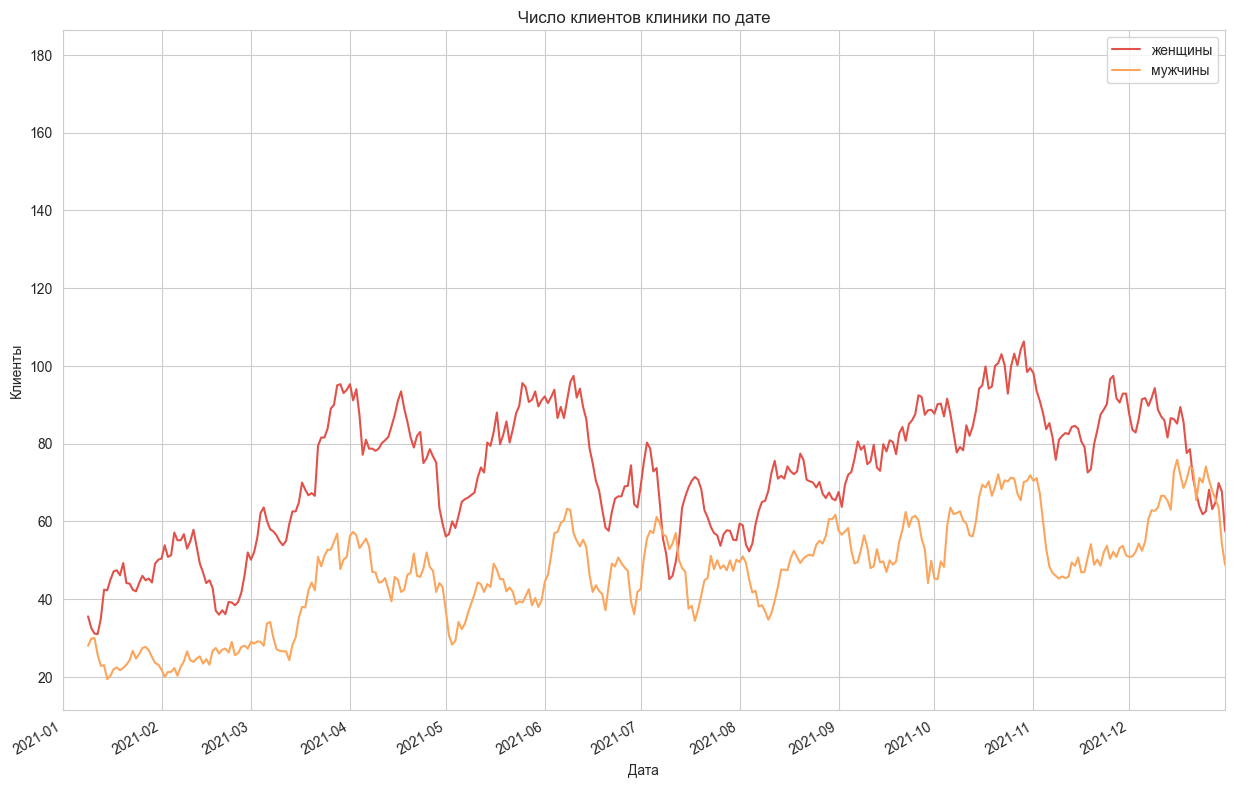

In [66]:
filter_data(insured_pivot_gender, 7).plot(grid=True, figsize=(15, 10), xlim=['2021-01-01', '2021-12-31'])
plt.legend()
plt.title('Число клиентов клиники по дате')
plt.xlabel('Дата')
plt.ylabel('Клиенты')
plt.show()

В 2021 году заметен тренд на увеличение числа клиентов.

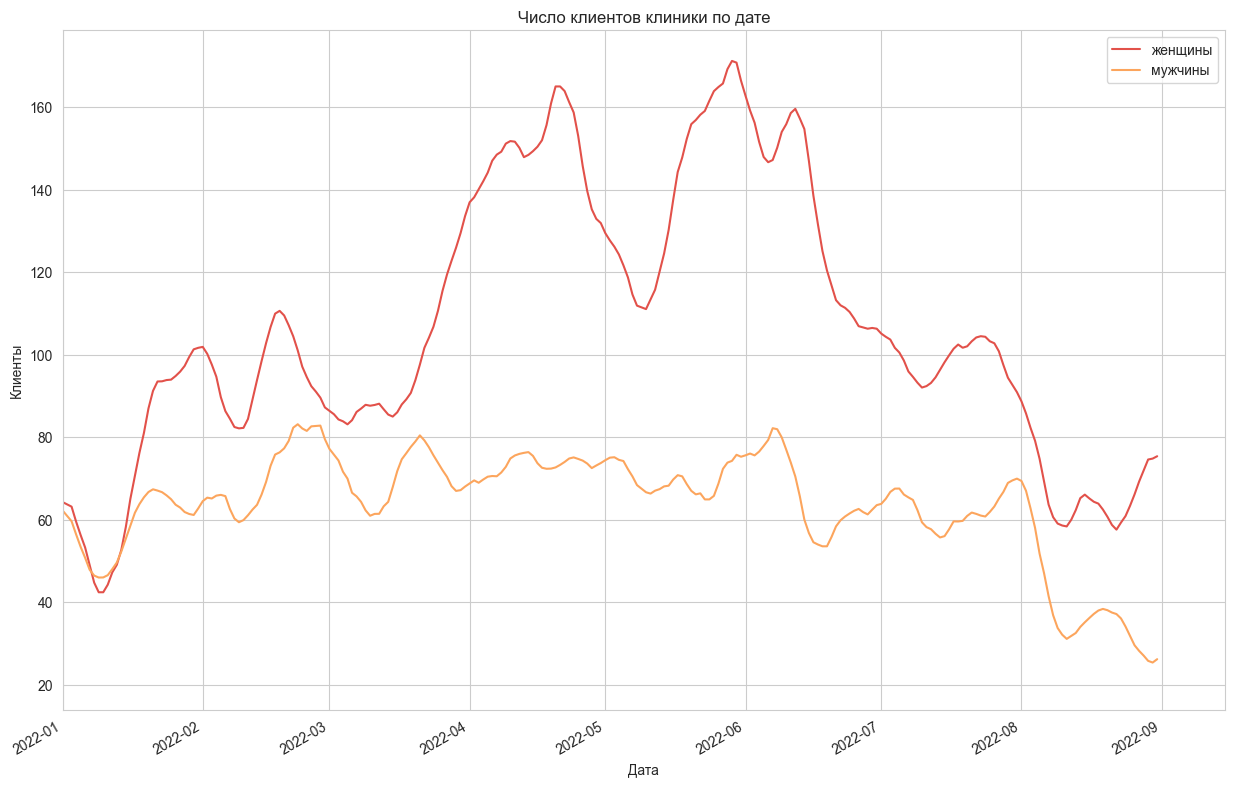

In [67]:
filter_data(insured_pivot_gender, 7).plot(grid=True, figsize=(15, 10), xlim=['2022-01-01', '2022-09-15'])
plt.legend()
plt.title('Число клиентов клиники по дате')
plt.xlabel('Дата')
plt.ylabel('Клиенты')
plt.show()

За 2022 год есть данные не за все месяцы, поэтому сложно сравнивать динамику, но просадка клиентов в майские праздники повторяется с 2021 годом.

Динамика мужчин не сильно меняется, по сравнению с динамикой женщин. Женщин больше и изменения в их посещении клиники выглядят заметнее. Сильно проседают по посещениям за 2022 год в майские праздники после всплеска с середины марта по апрель, который может быть связан с акциями на 8 марта. Второй скачок перед летним сезоном, т.к. никто не хочет летом ходить по врачам. 

Повторяющиеся элементы в динамике у мужчин и женщин говорят об поределённой "сезонности" посещений в зависимости от общих факторов (общих праздников, сезонов болезней, диспансеризаций, акций клиники без привязки к полу).

sex_category  женщины  мужчины
month                         
1                3562     2524
2                3925     2688
3                5640     3455
4                6783     3639
5                6795     3215
6                6035     3494
7                4796     3467
8                4132     2528
9                2475     1579
10               2880     2033
11               2579     1492
12               2319     1965

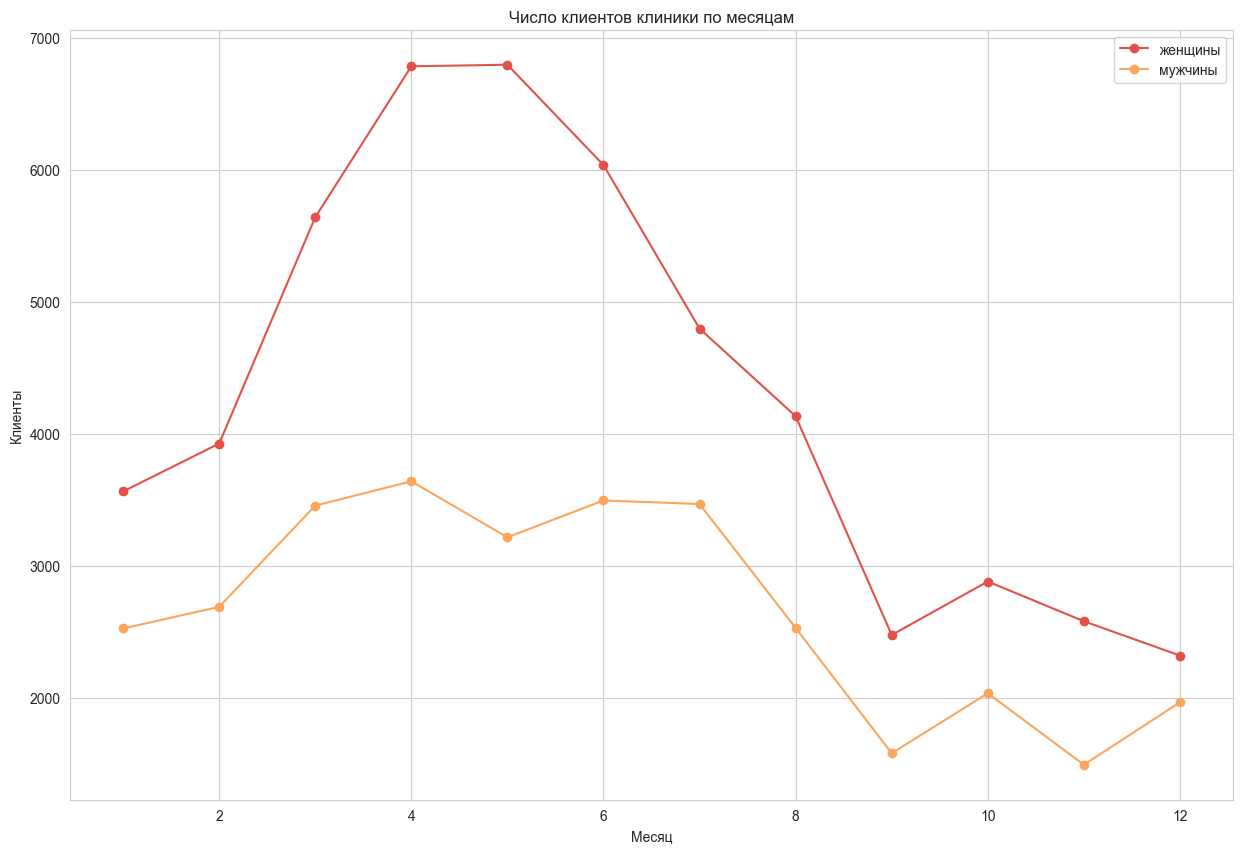

In [68]:
insured_pivot_mon = data.pivot_table(index='month',
                columns='sex_category',
                values='insured',
                aggfunc='count')
display(insured_pivot_mon)
insured_pivot_mon.plot(grid=True, figsize=(15, 10), style='o-')
plt.legend()
plt.title('Число клиентов клиники по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Клиенты')
plt.show()

Наплывы клиентов были самыми активными с февраля по начало июня среди женщин и с февраля по начало июля среди мужчин (по совокупным данным за 2021 и 2022 годы).

sex_category  женщины  мужчины
weekday                       
0                7544     4704
1                7908     4615
2                8246     5588
3                7701     4584
4                7676     4856
5                7165     4456
6                5681     3276

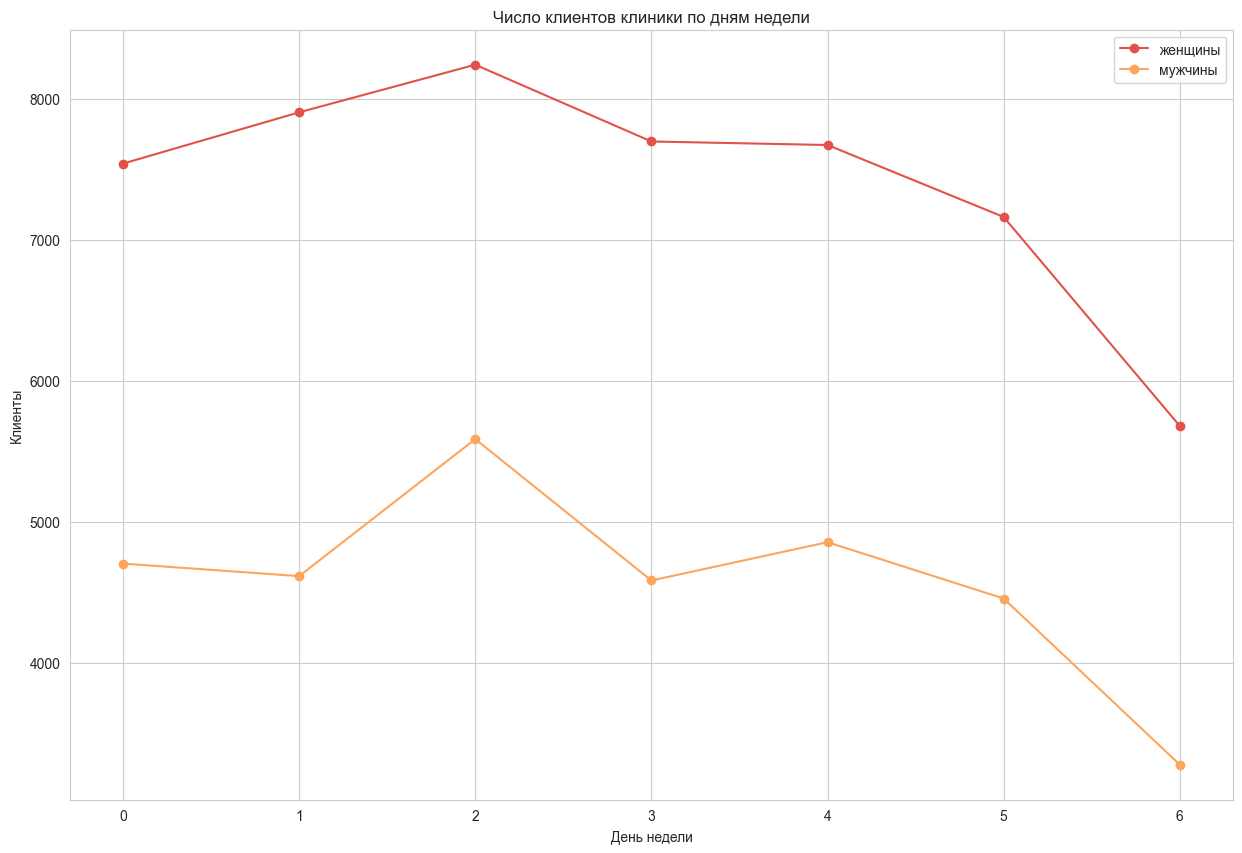

In [69]:
insured_pivot_w = data.pivot_table(index='weekday',
                columns='sex_category',
                values='insured',
                aggfunc='count')
display(insured_pivot_w)
insured_pivot_w.plot(grid=True, figsize=(15, 10), style='o-')
plt.legend()
plt.title('Число клиентов клиники по дням недели')
plt.xlabel('День недели')
plt.ylabel('Клиенты')
plt.show()

В начале недели клиенты чаще всего обращались в клинику, независимо от пола.

### <a id='toc1_4_2_'></a>[Статистика медицинских кейсов](#toc0_)

In [70]:
data_new.head()

record_id service_date  \
0  30268157003   2021-01-24   
1  30268157103   2021-01-24   
2  30268157203   2021-01-24   
3  30268157303   2021-01-24   
4  30268157403   2021-01-24   

                                                                                    service_name  \
0                                                                                прием первичный   
1                           взятие материала на посев цитологическое исследование риноцитограмма   
2  посев отдел дыхательных путей - слизистая зева с определением чувствительности к антибиотикам   
3                                                      общий анализ крови лейкоцитарная форм соэ   
4                                                                            ревматоидный фактор   

   service_amount  service_number  insured  sex_id  age_for_service_date  \
0            1470               1   490777       2                    26   
1             284               1   490777       2                    26   
2            1134               1   490777       2                    26   
3             693               1   490777       2                    26   
4             420               1   490777       2                    26   

  sex_category   price  month_cal  weekday  month  year month_year  \
0      женщины  1470.0 2021-01-01        6      1  2021    2021-01   
1      женщины   284.0 2021-01-01        6      1  2021    2021-01   
2      женщины  1134.0 2021-01-01        6      1  2021    2021-01   
3      женщины   693.0 2021-01-01        6      1  2021    2021-01   
4      женщины   420.0 2021-01-01        6      1  2021    2021-01   

        mnth_yr      diff  session_id between_services  
0  2021-January -163 days         NaN              NaT  
1  2021-January  -53 days         NaN              NaT  
2  2021-January    0 days         NaN              NaT  
3  2021-January    0 days         NaN              NaT  
4  2021-January    0 days         NaN              NaT

In [71]:
print('Число медицинских кейсов:', data_new.session_id.nunique())

Число медицинских кейсов: 16930


year     2021    2022
month                
1       828.0  2932.0
2       846.0  3226.0
3      1661.0  4075.0
4      2081.0  4397.0
5      2143.0  4453.0
6      2148.0  4358.0
7      2324.0  3705.0
8      2296.0  2368.0
9      2656.0     NaN
10     3315.0     NaN
11     2910.0     NaN
12     2945.0     NaN

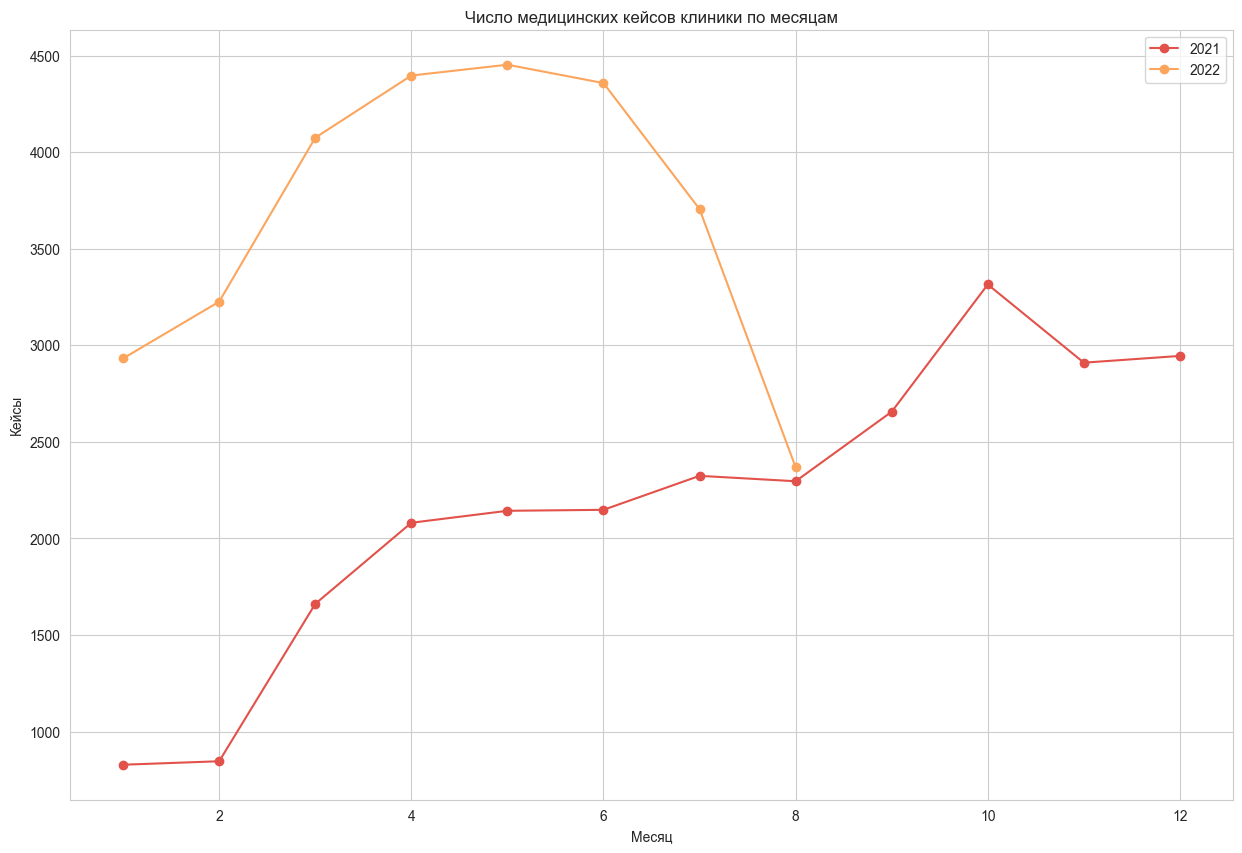

In [72]:
med_case_month = data_new.pivot_table(index='month',
                columns='year',
                values='session_id',
                aggfunc='count')
display(med_case_month)
med_case_month.plot(grid=True, figsize=(15, 10), style='o-', title='Число медицинских кейсов клиники по месяцам')
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Кейсы')
plt.show()

С июня 2022 года после майского пика, замедлив бурный рост в апреле, число медицинских кейсов начало сильно снижаться.

### <a id='toc1_4_3_'></a>[Статистика визитов](#toc0_)

In [73]:
visits_short = data[['month_cal', 'insured']].value_counts().reset_index(name='count')
visits_short.sort_values(by='month_cal')
display(visits_short)
visits = data.groupby(['service_date', 'insured'], as_index=False).agg(
    {'service_name':'count', 'service_amount':['mean', 'sum']}
)
visits.columns = visits.columns.map('_'.join)
visits = visits.rename(columns={'service_date_':'service_date', 'insured_':'insured'})
display(visits)

month_cal  insured  count
0     2021-03-01   490789     95
1     2022-03-01   194239     86
2     2022-04-01   221657     78
3     2021-10-01   634851     75
4     2022-08-01   418193     73
...          ...      ...    ...
10726 2022-05-01  1073484      1
10727 2021-03-01   512546      1
10728 2022-05-01  1073498      1
10729 2022-05-01  1073499      1
10730 2021-12-01   698355      1

[10731 rows x 3 columns]

service_date  insured  service_name_count  service_amount_mean  \
0       2021-01-03   142427                   1          1313.000000   
1       2021-01-03   142562                   1          1470.000000   
2       2021-01-03   174009                   4           696.000000   
3       2021-01-03   176359                   3          1281.333333   
4       2021-01-03   194308                   3           291.000000   
...            ...      ...                 ...                  ...   
30281   2022-08-31  1303034                   1          1620.000000   
30282   2022-08-31  1303046                   3          2726.666667   
30283   2022-08-31  1306753                   3           815.333333   
30284   2022-08-31  1306765                   3          2160.000000   
30285   2022-08-31  1306795                   1          1620.000000   

       service_amount_sum  
0                    1313  
1                    1470  
2                    2784  
3                    3844  
4                     873  
...                   ...  
30281                1620  
30282                8180  
30283                2446  
30284                6480  
30285                1620  

[30286 rows x 5 columns]

In [74]:
fig = px.scatter(visits, x='service_date', y='service_amount_sum', marginal_y='histogram')
annotations=[]
annotations.append(dict(xref='paper',yref='paper',x=0.0,y=1.0,
                       xanchor='left', yanchor='bottom',
                       text='Разброс стоимостей визитов по времени',
                       font=dict(size=18), showarrow=False))
fig.update_layout(annotations=annotations,
                  xaxis={'title':'Даты визитов', 'showticklabels':True},
                  yaxis={'title':'Стоимость визита', 'showticklabels':True})
fig.show()

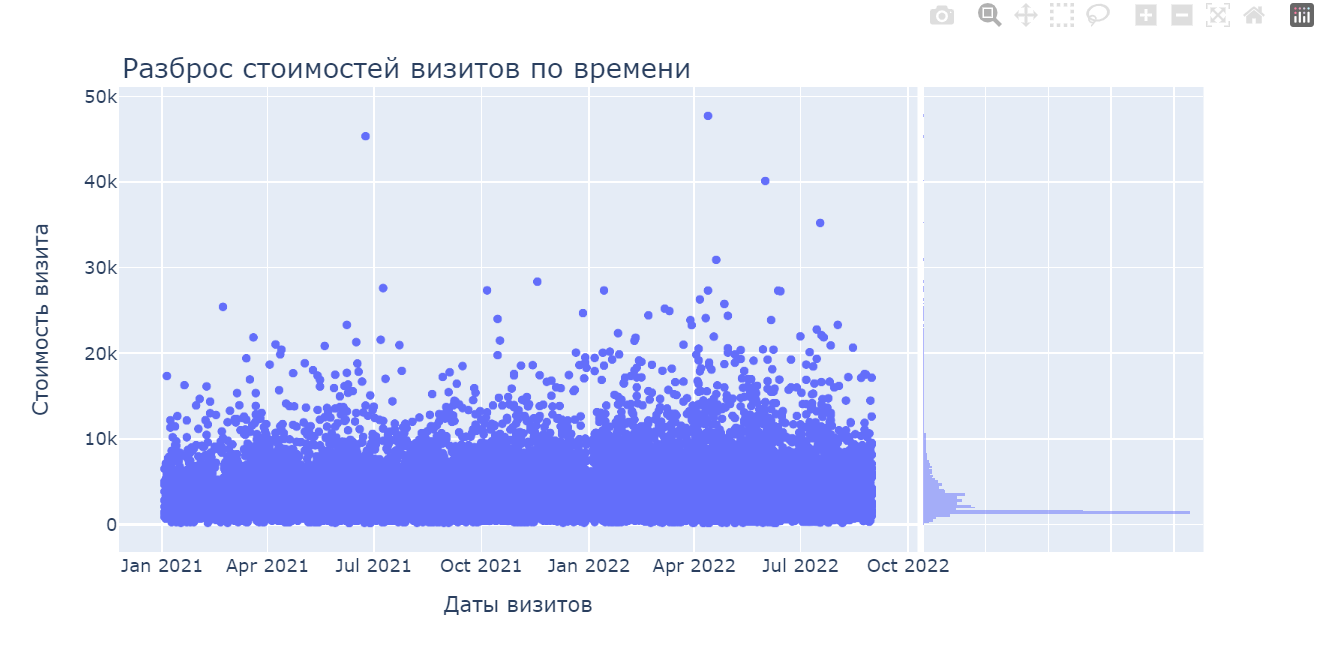

По графику заметно незначительное увеличение стоимости визитов. Такая тенденция не могла повлиять на снижение стоимости обслуживания пациентов.

## <a id='toc1_5_'></a>[Общий вывод](#toc0_)

Цель исследования была достигнута.

Наблюдается общая тенденция к возрастанию выручки за месяц с небольшими откатами, а также тенденцией к снижению с апреля 2022 года по август 2022 года.

**Были выдвинуты гипотезы изменения стоимости услуг клиники.**
1. Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги.
2. Средняя стоимость обслуживания пациентов изменилась из-за изменения числа медицинских кейсов.
3. Средняя стоимость обслуживания пациентов изменилась из-за изменения стоимостей визитов.
4. Средняя стоимость обслуживания пациентов изменилась из-за изменения числа клиентов.

В результате проведённого исследования удалось выяснить, что динамика стоимости услуг в клинике почти полностью повторяет динамику цен оказанных услуг. Сложно судить об изменении цен на конкретные услуги, поэтому  нельзя с уверенностью принимать ПЕРВУЮ ГИПОТЕЗУ о влиянии изменения цен на изменение доходов клиники.

С июня 2022 года после майского пика, замедлив бурный рост в апреле, число медицинских кейсов начало сильно снижаться. Поэтому ВТОРУЮ ГИПОТЕЗУ можно подтвердить.

ТРЕТЬЮ ГИПОТЕЗУ можно опровергнуть отсутствием ощутимого изменения стоимости визитов за весь анализируемый период. Наблюдается незначительное увеличение стоимости визитов. Такая тенденция не могла повлиять на снижение стоимости обслуживания пациентов.

Касаемо числа клиентов, динамика мужчин не сильно меняется, по сравнению с динамикой женщин. Женщин больше и изменения в их посещении клиники выглядят заметнее. Сильно проседают по посещениям за 2022 год в майские праздники после всплеска с середины марта по апрель, который может быть связан с акциями на 8 марта. Второй скачок перед летним сезоном, т.к. никто не хочет летом ходить по врачам. 

Повторяющиеся элементы в динамике у мужчин и женщин говорят об поределённой "сезонности" посещений в зависимости от общих факторов (общих праздников, сезонов болезней, диспансеризаций, акций клиники без привязки к полу).

Сезонность сказалась на динамике, но тенденция к снижению числа клиентов в 2022 году не объясняется, хотя и может влиять на снижение доходов клиники, что подтверждает ЧЕТВЁРТУЮ ГИПОТЕЗУ.

***Таким образом, удалось подтвердить вторую и четвёртую гипотезу о влиянии медицинских кейсов и числа клиентов на снижение выручки клиники.***

---

**Кроме того, были отмечены некоторые интересные особенности.**

Услуг из категории `другое` много, но доходы по ним меньше, чем по услугам из других категорий. Менее популярные `консультации` опережают остальные категории по доходам. В 2022 году разрыв между этими категориями сильно увеличился во многом из-за больших сумм от `консультации`.

Несмотря на неполноту данных за 2022 год, распределение выручки по категориям не меняется в 2022 году, по сравнению с 2021 годом. `Консультации` и `диагностика` даже успели принести больше денег, чем в 2021 году.

Исходя из обращений, средние чеки мужчин и женщин выше, чем медианные. Это говорит о выбросах с высокими чеками. Кроме того, у мужчин средние и медианные чеки выше, чем у женщин.